# Tabula Muris data analysis (FACS sorted)

# Contents
- [Imports](#Imports)
- [Data](#Data)
  - [View tissue and cell type distribution](#View-tissue-and-cell-type-distribution)
  - [Visualize cell type, tissue, and mouse distribution](#Visualize-cell-type,-tissue,-and-mouse-distribution)
    - [Closer look at tissues and cell types](#Closer-look-at-tissues-and-cell-types)
  - [Filter to HVGs](#Filter-to-HVGs)
- [Feature Correlation](#Feature-Correlation)
- [Feature Importance](#Feature-Importance)
  - [Permutation Importance](#Permutation-Importance)
    - [All features](#All-features)
    - [De-colineated](#De-colineated)
  - [Logistic Regression (LASSO)](#Logistic-Regression-(LASSO))
    - [Check for discriminative signal on PCs](#Check-for-discriminative-signal-on-PCs)
    - [Exploration of sparsity vs accuracy tradeoff](#Exploration-of-sparsity-vs-accuracy-tradeoff)
    - [Simple model fitting](#Simple-model-fitting)
  - [Tree-based](#Tree-based)
    - Fitted models
- [DE Analysis](#DE-Analysis)
  - [Preprocessing](#Preprocessing)
  - [Grouped by Cell Type](#Grouped-by-Cell-Type)
  - [Grouped by Tissue](#Grouped-by-Tissue)

# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import defaultdict

import scanpy as sc
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd

from Bio.Cluster import distancematrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Data

In [2]:
metadata = pd.read_csv("data/tabula_muris/metadata_FACS.csv")
annotations = pd.read_csv("data/tabula_muris/annotations_facs.csv")
annotations.set_index('cell', inplace=True)

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## View tissue and cell type distribution

In [3]:
ct_tissue_freq = annotations.value_counts(["cell_ontology_class", "tissue"])
ct_tissue_freq = ct_tissue_freq.unstack(level=1)
ct_tissue_freq.fillna(0., inplace=True)
ct_tissue_freq = ct_tissue_freq.astype(int)
ct_tissue_freq['num_tissues'] = (ct_tissue_freq > 0).sum(axis=1)
ct_tissue_freq.sort_values(by="num_tissues", ascending=False, inplace=True)
ct_tissue_freq.loc['num_celltypes'] = (ct_tissue_freq > 0).sum(axis=0)
ct_tissue_freq.sort_values(by="num_celltypes", axis=1, ascending=False, inplace=True)
ct_tissue_freq.to_csv("data/tabula_muris/tabulated_ct_and_tissue.csv")

In [4]:
ct_tissue_freq

tissue,num_tissues,Marrow,Lung,Pancreas,Brain_Non-Myeloid,Heart,Limb_Muscle,Fat,Skin,Liver,...,Kidney,Diaphragm,Mammary_Gland,Trachea,Aorta,Spleen,Thymus,Bladder,Brain_Myeloid,Tongue
cell_ontology_class,,,,,,,,,,,,,,,,,,,,,
endothelial cell,10,0,0,66,715,1177,141,668,0,0,...,126,78,47,113,188,0,0,0,0,0
macrophage,6,173,0,0,0,0,45,0,0,0,...,37,31,0,0,0,48,0,0,61,0
leukocyte,6,0,35,54,0,523,0,0,15,0,...,16,0,0,0,0,0,40,0,0,0
B cell,6,44,57,0,0,0,71,519,0,41,...,0,0,0,0,0,1297,0,0,0,0
T cell,4,0,53,0,0,0,35,353,0,0,...,0,0,0,0,0,352,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
epithelial cell,1,0,0,0,0,0,0,0,0,0,...,0,0,0,201,0,0,0,0,0,0
epidermal cell,1,0,0,0,0,0,0,0,276,0,...,0,0,0,0,0,0,0,0,0,0
enteroendocrine cell,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Back to Contents](#Contents)

## Load expression data

In [3]:
# def load_data(annotations, tissues, cell_types):
def load_data(annotations, tissues, cell_types=None): # don't filter by cell types just yet, we want other cell types in there for the marker gene finding
    all_data = []
    for tiss in tissues:
        print(f"data/tabula_muris/FACS/{tiss}-counts.csv")
        cur_df = pd.read_csv(f"data/tabula_muris/FACS/{tiss}-counts.csv", index_col=0)
        cur_df = cur_df.T
        common_idx = cur_df.index.intersection(annotations.index)
        cur_meta = annotations.loc[common_idx]
        cur_df = cur_df.loc[common_idx]
        cur_adata = anndata.AnnData(X=cur_df, obs=cur_meta)
        print(cur_adata.shape)
        if cell_types is not None:
            cur_adata = cur_adata[cur_adata.obs['cell_ontology_class'].isin(cell_types)]
        print(cur_adata.shape)
        all_data.append(cur_adata)
    all_data = anndata.concat(all_data)
    return all_data

In [4]:
adata = load_data(annotations, ['Lung', 'Limb_Muscle', 'Fat', 'Spleen'], ['B cell', 'T cell', 'natural killer cell'])

data/tabula_muris/FACS/Lung-counts.csv
(1716, 23433)
(147, 23433)
data/tabula_muris/FACS/Limb_Muscle-counts.csv
(1090, 23433)
(106, 23433)
data/tabula_muris/FACS/Fat-counts.csv
(4967, 23433)
(967, 23433)
data/tabula_muris/FACS/Spleen-counts.csv
(1697, 23433)
(1649, 23433)


In [5]:
adata_all = load_data(annotations, ['Lung', 'Limb_Muscle', 'Fat', 'Spleen'])

data/tabula_muris/FACS/Lung-counts.csv
(1716, 23433)
(1716, 23433)
data/tabula_muris/FACS/Limb_Muscle-counts.csv
(1090, 23433)
(1090, 23433)
data/tabula_muris/FACS/Fat-counts.csv
(4967, 23433)
(4967, 23433)
data/tabula_muris/FACS/Spleen-counts.csv
(1697, 23433)
(1697, 23433)


In [6]:
adata_all.shape

(9470, 23433)

In [7]:
adata.shape

(2869, 23433)

In [8]:
adata.obs['tissue'].value_counts(dropna=False)

Spleen         1649
Fat             967
Lung            147
Limb_Muscle     106
Name: tissue, dtype: int64

In [9]:
adata_all.obs['cell_ontology_class'].value_counts(dropna=False)

mesenchymal stem cell of adipose                   2107
B cell                                             1944
myeloid cell                                       1208
endothelial cell                                    809
T cell                                              793
lung endothelial cell                               693
skeletal muscle satellite cell                      540
stromal cell                                        423
mesenchymal stem cell                               258
NaN                                                 142
natural killer cell                                 132
epithelial cell of lung                             113
macrophage                                           93
classical monocyte                                   90
monocyte                                             65
leukocyte                                            35
ciliated columnar cell of tracheobronchial tree      25
Name: cell_ontology_class, dtype: int64

In [10]:
nans = adata_all.obs['cell_ontology_class'].isna()
adata_all = adata_all[~nans]

[Back to Contents](#Contents)

## Visualize cell type, tissue, and mouse distribution

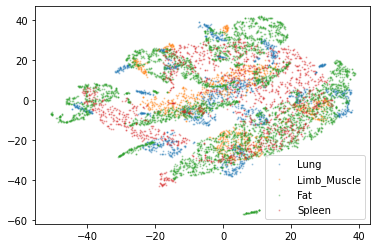

In [204]:
for tiss in adata.obs['tissue'].unique():
    subset = adata.obs[adata.obs['tissue'] == tiss]
    plt.scatter(subset['tissue_tSNE_1'], subset['tissue_tSNE_2'], s=1, alpha=0.3 ,label = tiss)
plt.legend()

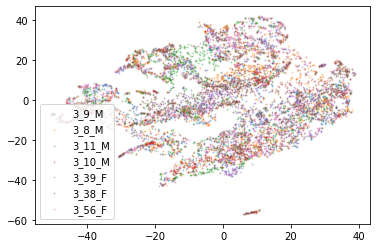

In [207]:
for mouse in adata.obs['mouse.id'].unique():
    subset = adata.obs[adata.obs['mouse.id'] == mouse]
    plt.scatter(subset['tissue_tSNE_1'], subset['tissue_tSNE_2'], s=1, alpha=0.3 ,label = mouse)
plt.legend()

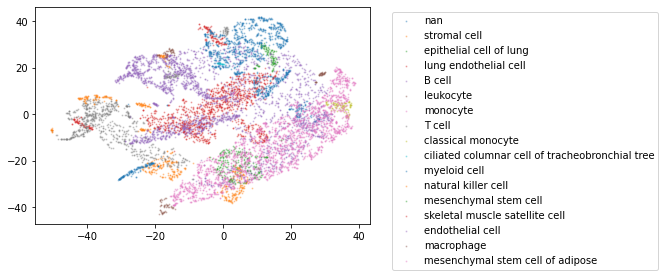

In [210]:
for ct in adata.obs['cell_ontology_class'].unique():
    subset = adata.obs[adata.obs['cell_ontology_class'] == ct]
    plt.scatter(subset['tissue_tSNE_1'], subset['tissue_tSNE_2'], s=1, alpha=0.3 ,label = ct)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

[Back to Contents](#Contents)

### Closer look at tissues and cell types

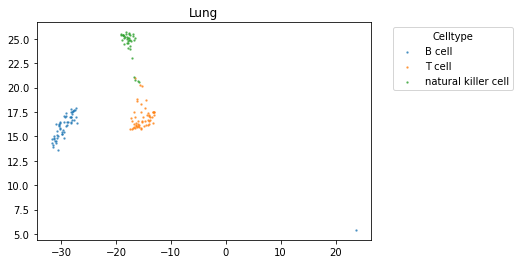

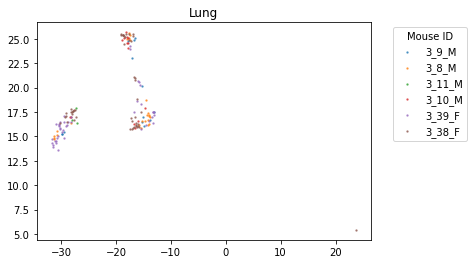

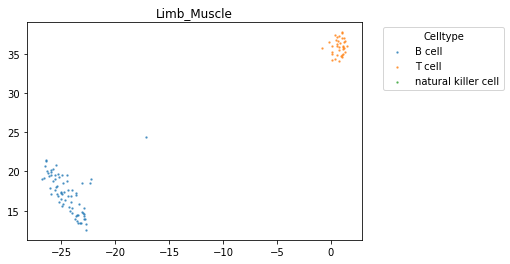

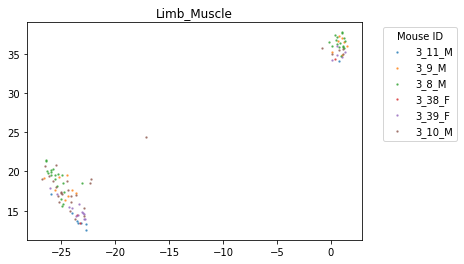

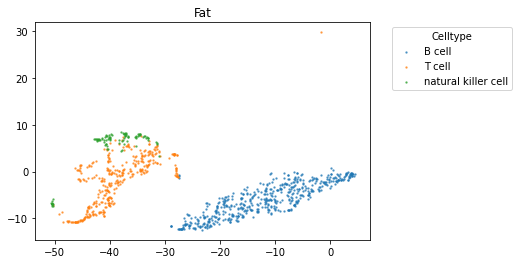

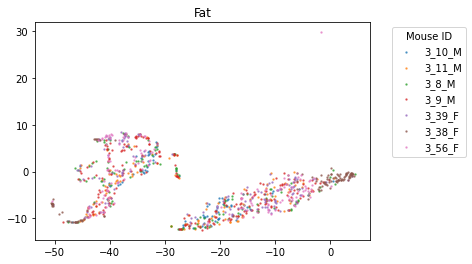

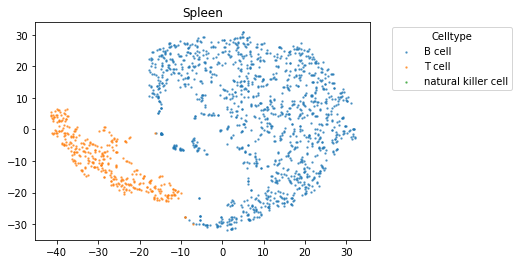

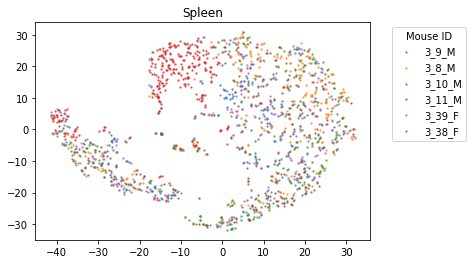

In [11]:
for tiss in adata.obs['tissue'].unique():
    subset = adata.obs[adata.obs['tissue'] == tiss]
    for ct in ['B cell', 'T cell', 'natural killer cell']:
        ct_subset = subset[subset['cell_ontology_class'] == ct]
        plt.scatter(ct_subset['tissue_tSNE_1'], ct_subset['tissue_tSNE_2'], s=2, alpha=0.6 ,label = ct)
    plt.legend(title="Celltype", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(tiss)
    plt.savefig(f"tabula_muris_plots/{tiss}-celltypes.png", bbox_inches="tight")
    plt.show()
    subset = subset[subset['cell_ontology_class'].isin(['B cell', 'T cell', 'natural killer cell'])]
    for mouse in subset['mouse.id'].unique():
        m_subset = subset[subset['mouse.id'] == mouse]
        plt.scatter(m_subset['tissue_tSNE_1'], m_subset['tissue_tSNE_2'], s=2, alpha=0.6 ,label = mouse)
    plt.legend(title="Mouse ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(tiss)
    plt.savefig(f"tabula_muris_plots/{tiss}-mouse.png", bbox_inches="tight")
    plt.show()

[Back to Contents](#Contents)

## Filter to HVGs

In [11]:
def filter_hvg(adata):
    log_normed = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(log_normed)
    adata.var['highly_variable'] = log_normed.var['highly_variable']
    adata.var['dispersions_norm'] = log_normed.var['dispersions_norm']
    highly_variable = adata.var.index[adata.var['highly_variable'] == True]
    return adata[:, highly_variable], highly_variable

[Back to Contents](#Contents)

# Feature Correlation

Checkout [this guide](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) on feature correlation

In [12]:
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")

Initial data shape: (9328, 23433)


Trying to set attribute `.var` of view, copying.


After hvg shape: (9328, 5127)
	Removed 18306 genes


computing feature permutation importances...
done.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


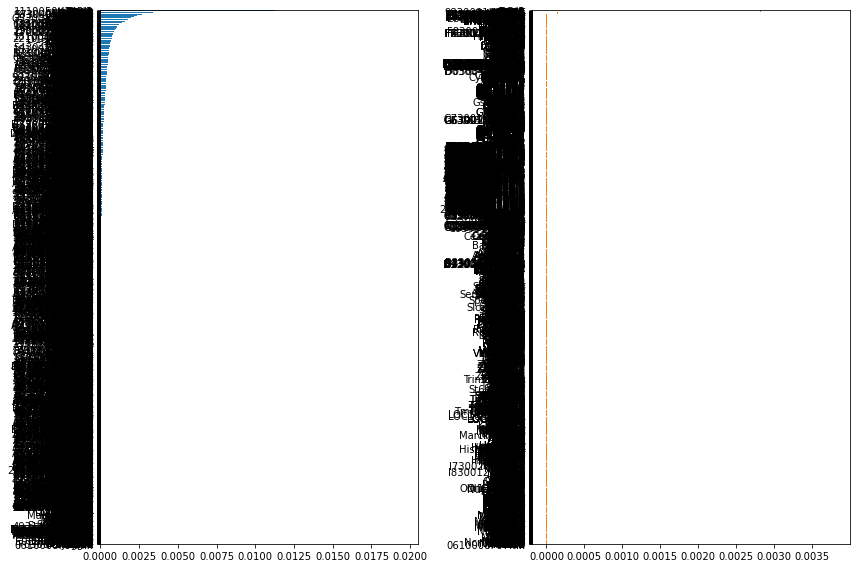

In [24]:
print("computing feature permutation importances...")
result = permutation_importance(clf, X_train, y_train, n_repeats=1,
                                random_state=42)
print("done.")
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(adata_all_hvg.var_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=adata_all_hvg.var_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

Initial data shape: (9328, 23433)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After hvg shape: (9328, 5127)
	Removed 18306 genes
computing feature correlations


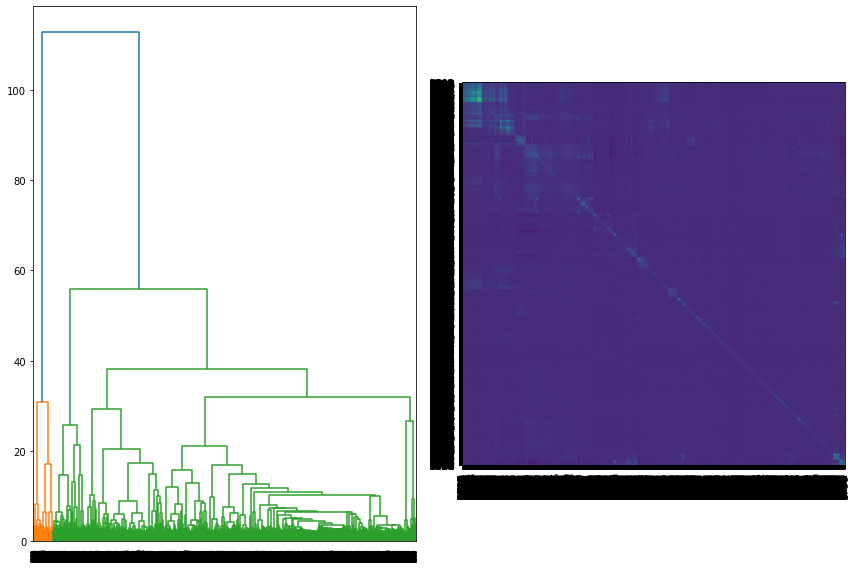

In [46]:
X = adata_all_hvg.X

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
print("computing feature correlations...")
corr = spearmanr(X).correlation
print("done.")
print("computing hierarchical clustering...")
corr_linkage = hierarchy.ward(corr)
print("done.")
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

computing feature correlations...
(5127, 5127)
[1. 1. 1. ... 1. 1. 1.]
done.
computing hierarchical clustering...
done.


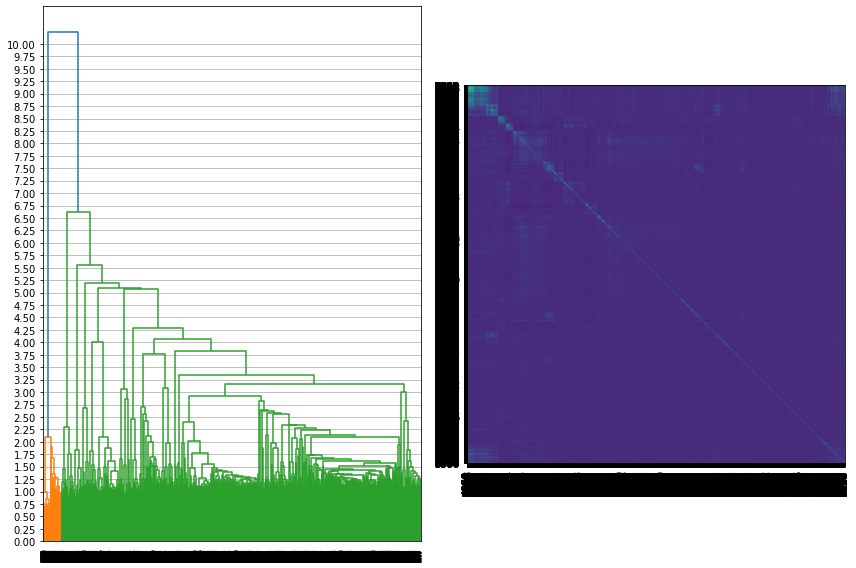

In [13]:
X = adata_all_hvg.X

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
print("computing feature correlations...")
corr = spearmanr(X).correlation
# Force to be exactly symmetric, it's "close" to being symmetric
# corr = np.tril(corr) + np.triu(corr.T, 1)
corr = np.around(corr, 3)
# dist_matrix = distancematrix(X, transpose=1, dist='s')
print(corr.shape)
print(np.diag(corr))
print("done.")
print("computing hierarchical clustering...")
# convert the redundant n*n square matrix form into a condensed nC2 array
dist_array = ssd.squareform(1. - corr) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
corr_linkage = hierarchy.ward(dist_array)
print("done.")
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax1.grid('on', axis='y')
ax1.set_yticks(np.arange(0, 10.1, 0.25))
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

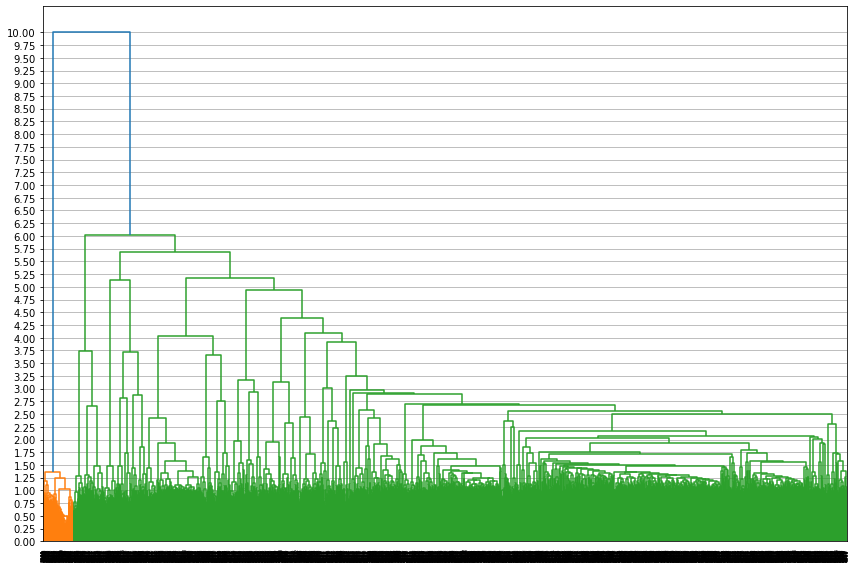

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax1.grid('on', axis='y')
ax1.set_yticks(np.arange(0, 10.1, 0.25))
fig.tight_layout()
plt.show()

In [10]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1.25, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_clusters = []
selected_features = []
for cluster_id, members in cluster_id_to_feature_ids.items():
    selected_clusters.append(cluster_id)
    selected_features.append(members[0])

In [11]:
len(selected_features)

257

In [12]:
adata_de_colineated = adata_all_hvg[:, selected_features]
print(adata_de_colineated.shape)

(9328, 257)


[Back to Contents](#Contents)

In [14]:
def get_feature_clustered_median_adata(adata, corr_linkage, k):
    cluster_ids = hierarchy.fcluster(corr_linkage, k, criterion='maxclust')
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    X_medians = []
    var_names = []
    for cluster_id, members in cluster_id_to_feature_ids.items():
        feature_cluster_subset = adata[:, members].X
        feature_cluster_median = np.median(feature_cluster_subset, axis=1, keepdims=True)
        X_medians.append(feature_cluster_median)
        var_names.append(cluster_id)
    X_medians = np.hstack(X_medians)
    adata_de_colineated_medians = anndata.AnnData(X=X_medians, obs=adata.obs, var=pd.DataFrame(index=var_names))
    print(adata_de_colineated_medians.shape)
    return adata_de_colineated_medians, cluster_id_to_feature_ids, var_names

In [20]:
def get_clf_score(adata, var1_key='cell_ontology_class', var1_subset=None, var2_key='tissue'):
    if var1_subset is None:
        var1_subset = adata.obs[var1_key].unique()
    accuracies = []
    for v1 in var1_subset:
        # print(v1)
        adata_sub = adata[adata.obs[var1_key] == v1]
        X = adata_sub.X
        y = adata_sub.obs[var2_key]
        clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        clf.fit(X, y)
        #print("Accuracy on train data: {:.2f}".format(clf.score(X, y)))
        accuracies.append(clf.score(X, y))
    return np.mean(accuracies)

def get_clf_score_val(adata, var1_key='cell_ontology_class', var1_subset=None, var2_key='tissue'):
    if var1_subset is None:
        var1_subset = adata.obs[var1_key].unique()
    train_accuracies = []
    val_accuracies = []
    for v1 in var1_subset:
        # print(v1)
        adata_sub = adata[adata.obs[var1_key] == v1]
        X = adata_sub.X
        y = adata_sub.obs[var2_key]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
        
        clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        clf.fit(X_train, y_train)
        #print("Accuracy on train data: {:.2f}".format(clf.score(X, y)))
        train_accuracies.append(clf.score(X_train, y_train))
        val_accuracies.append(clf.score(X_test, y_test))
    print(f"avg train_acc: {np.mean(train_accuracies)}")
    return np.mean(val_accuracies)

acc_drop_limit = 0.1
k = 1100
k_step = 1
k_min = 1089
base_accuracy = get_clf_score_val(adata_all_hvg, var1_key="cell_ontology_class", var1_subset=['B cell', 'T cell', 'natural killer cell'])
print(f"base_acc: {base_accuracy}")
while k > k_min:
    adata_decolineated_medians, _, _ = get_feature_clustered_median_adata(adata_all_hvg, corr_linkage, k)
    acc = get_clf_score_val(adata_decolineated_medians, var1_key="cell_ontology_class", var1_subset=['B cell', 'T cell', 'natural killer cell'])
    print(f"{k}: {acc}")
    delta = base_accuracy - acc
    if delta > 0 and (delta / base_accuracy) > acc_drop_limit:
        break
    k -= k_step

avg train_acc: 1.0
base_acc: 0.7249491001584804


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(9328, 1100)
avg train_acc: 0.9648335203890759
1100: 0.6655437055585948


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(9328, 1099)
avg train_acc: 0.9648335203890759
1099: 0.6517100404128136


In [21]:
# cluster_ids = hierarchy.fcluster(corr_linkage, 1.1, criterion='distance')
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_clusters = []
# selected_features = []
# for cluster_id, members in cluster_id_to_feature_ids.items():
#     selected_clusters.append(cluster_id)
#     selected_features.append(members[0])
adata_decolineated, cluster_id_to_feature_ids, selected_clusters = get_feature_clustered_median_adata(adata_all_hvg, corr_linkage, 1100)
print(len(cluster_id_to_feature_ids))

(9328, 1100)
1100


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Feature Importance

## Permutation Importance

In [16]:
random_state = 42

In [63]:
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")

Initial data shape: (9470, 23433)
After hvg shape: (9470, 5109)
	Removed 18324 genes


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [22]:
def permutation_feature_importance(adata, n_repeats=5, var1_key='cell_ontology_class', var1_subset=None, var2_key='tissue'):
    if var1_subset is None:
        var1_subset = adata.obs[var1_key].unique()
    FI_dict = {}
    for v1 in var1_subset:
        print(v1)
        adata_sub = adata[adata.obs[var1_key] == v1]
        X = adata_sub.X
        y = adata_sub.obs[var2_key]
        clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        clf.fit(X, y)
        print("Accuracy on train data: {:.2f}".format(clf.score(X, y)))
        FI = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state)
        FI_dict[v1] = FI
    FI_final = {}
    FI_orig = {}
    for v1 in var1_subset:
        FI_orig[v1] = FI_dict[v1].importances_mean
        FI = FI_dict[v1].importances_mean
        FI_other_sum = np.zeros_like(FI)
        for v1_other in var1_subset:
            if v1 == v1_other:
                continue
            FI_other = FI_dict[v1_other].importances_mean
            FI_other_sum += FI_other
        FI_other = FI_other_sum / (len(var1_subset) - 1)
        FI_final[v1] = FI - FI_other
    return FI_final, FI_orig

### All features

In [22]:
FI_normalized, FI_orig = permutation_feature_importance(adata_all_hvg, n_repeats=1, var1_subset=['B cell', 'T cell', 'natural killer cell'])

B cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Accuracy on train data: 1.00
T cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Accuracy on train data: 1.00
natural killer cell
Accuracy on train data: 1.00


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [23]:
for ct in FI_normalized.keys():
    print(ct)
    print(FI_normalized[ct].shape)
    sort_idx = np.argsort(FI_normalized[ct])[::-1]
    print(adata_all_hvg.var_names[sort_idx][:10])
    print(FI_normalized[ct][sort_idx][:10])
    print(FI_orig[ct][sort_idx][:10])
    s = ', '.join(adata_all_hvg.var_names[sort_idx][:10])
    print(s)
    for g in adata_all_hvg.var_names[sort_idx][:25]:
        print(g)
    print()

B cell
(5109,)
Index(['Neil1', 'Gcg', 'Dtx1', 'Cpm', 'Ltf', 'Cenpa', 'Krt13', 'Iapp', 'Cpa1',
       'Krt5'],
      dtype='object')
[0.00462963 0.00257202 0.00154321 0.00154321 0.00102881 0.00102881
 0.00102881 0.0005144  0.0005144  0.0005144 ]
[0.00462963 0.00257202 0.00154321 0.00154321 0.00102881 0.00102881
 0.00102881 0.0005144  0.0005144  0.0005144 ]
Neil1, Gcg, Dtx1, Cpm, Ltf, Cenpa, Krt13, Iapp, Cpa1, Krt5
Neil1
Gcg
Dtx1
Cpm
Ltf
Cenpa
Krt13
Iapp
Cpa1
Krt5
Tmem8c
Slc14a1
Zkscan14
Uhmk1
Cx3cr1
Zc3h10
Tmem41a
Zc3h12b
Itga6
Fcrl5
Chst3
E130309F12Rik
E130310I04Rik
E130215H24Rik
E130114P18Rik

T cell
(5109,)
Index(['Zyg11a', 'E230025N22Rik', 'E130112N10Rik', 'E130114P18Rik',
       'E130215H24Rik', 'E130309F12Rik', 'E130310I04Rik', 'E130317F20Rik',
       'E230008N13Rik', 'E2f6'],
      dtype='object')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Zyg11a, E230025N22Rik, E130112N10Rik, E130114P18Rik, E130215H24Rik, E130309F12Rik, E130310I04Rik, E130317F20Rik, E230008N

In [ ]:
for ct in FI_normalized.keys():
    print(ct)
    sort_idx = np.argsort(FI_result[ct])[::-1]
    print(adata_all_hvg.var_names[sort_idx][:10])
    print(FI_result[ct][sort_idx][:10])

[Back to Contents](#Contents)

### De-colineated

In [23]:
FI_normalized_decolineated, FI_orig_decolineated = permutation_feature_importance(adata_decolineated, n_repeats=1, var1_subset=['B cell', 'T cell', 'natural killer cell'])

B cell
Accuracy on train data: 0.92
T cell
Accuracy on train data: 0.97
natural killer cell
Accuracy on train data: 1.00


In [16]:
# Print the clusters that the top features are members of
for ct in FI_normalized_decolineated.keys():
    print(ct)
    print()
    FI = FI_normalized_decolineated[ct]
    sort_idx = np.argsort(FI)[::-1]
#     sorted_var_names = adata_de_colineated.var_names[sort_idx]
    selected_clusters = np.array(selected_clusters)
    sorted_cluster_ids = selected_clusters[sort_idx]
    for i in range(3):
        members = cluster_id_to_feature_ids[sorted_cluster_ids[i]]
        for feat in members:
            print(adata_all_hvg.var_names[feat])
        print()
    print()

B cell

Bfsp2
Cacna1e
Chst3
Cnr2
Dtx1
Edaradd
Ell3
Fam129c
Fcrl5
Haao
Irf4
Kmo
Pgap1
Srpk3

Cx3cr1
Gpr34
Lair1
Lilra5
Lpcat2
P2ry13
Siglech
Smpdl3b
Spic
Trem2

A430084P05Rik
Amz1
Bcl2a1a
Bcl2a1d
Ccl17
Ebi3
Gatm
Gna15
Gpr68
Havcr2
Hepacam2
Itgae
Klrb1b
Ppfia4
Slamf8
Slc46a3
Timd4
Tmem8
Xlr


T cell

Bend4
Cd163
Cd200r1
Cd209c
Clec4b1
Clec4g
Ctnnd2
Cysltr1
Ptchd1
Scn2b
Sv2b
Tbxas1
Tnf
Tnip3

Camk4
Cd4
Cd5
Cd6
Cd96
Cst7
Ctse
Dapl1
Dennd2d
Fam169b
Gm11346
Jakmip1
Lime1
Pacsin1
Prkcq
Rab37
Sit1
Tespa1
Tnfrsf26
Txk
Ubash3a

1190002N15Rik
1200009I06Rik
Amph
Arsj
B130024G19Rik
Fads2
Fam13a
Foxs1
Gsta3
Hdhd3
Heyl
Hspb2
Jph2
Kcns3
Klf15
Lclat1
Ncald
Nexn
Nrxn2
Palm2
Prkg2
Ptprd
Pygm
Rasl12
Rem1
Selenbp2
Shisa2
Slc1a3
Sort1
Stard13
Tbx5
Tmem200b
Tmem38b
Wisp1


natural killer cell

Eomes
Fasl
Ifng
Il18rap
Klra13-ps
Klra14
Klra3
Klra4
Klra7
Klra8
Klra9
Klrb1a
Klrb1f
Klrc1
Klrc3
Klre1
Klrg1
Klri2
Samd3
Serpinb9b
Styk1
Tbx21
Tmsb15a
Xcl1

A430084P05Rik
Amz1
Bcl2a1a
Bcl2a1d
Ccl17
Ebi3
Gatm
Gna15
Gpr6

In [24]:
def DE_on_counts(count_data, groupby, test='wilcoxon'):
    sc.pp.calculate_qc_metrics(count_data, percent_top=None, log1p=False, inplace=True)
    sc.pp.normalize_total(count_data)
    sc.pp.log1p(count_data)
    sc.pp.regress_out(count_data, ['total_counts'])
    sc.pp.scale(count_data)
    sc.tl.rank_genes_groups(count_data, groupby=groupby, n_genes=count_data.shape[1], method='wilcoxon')
    de_dfs = {}
    for group in count_data.obs[groupby].unique():
        de_dfs[group] = sc.get.rank_genes_groups_df(count_data, group=group)
    return de_dfs

# def DE_on_counts2(count_data, groupby, test='wilcoxon'):
# #     sc.pp.calculate_qc_metrics(count_data, percent_top=None, log1p=False, inplace=True)
# #     sc.pp.normalize_total(count_data)
# #     sc.pp.log1p(count_data)
# #     sc.pp.regress_out(count_data, ['total_counts'])
# #     sc.pp.scale(count_data)
#     sc.tl.rank_genes_groups(count_data, groupby=groupby, n_genes=count_data.shape[1], method='wilcoxon')
#     de_dfs = {}
#     for group in count_data.obs[groupby].unique():
#         de_dfs[group] = sc.get.rank_genes_groups_df(count_data, group=group)
#     return de_dfs

def DE_on_counts2(count_data, groupby, celltype, gene_clust_id, gene_clust_rank, test='wilcoxon'):
#     sc.pp.calculate_qc_metrics(count_data, percent_top=None, log1p=False, inplace=True)
#     sc.pp.normalize_total(count_data)
#     sc.pp.log1p(count_data)
#     sc.pp.regress_out(count_data, ['total_counts'])
#     sc.pp.scale(count_data)
    sc.tl.rank_genes_groups(count_data, groupby=groupby, n_genes=count_data.shape[1], method='wilcoxon')
    de_dfs = {}
    for group in count_data.obs[groupby].unique():
        df = sc.get.rank_genes_groups_df(count_data, group=group)
        df[groupby] = group
        df['celltype'] = celltype
        df['gene_clust_id'] = gene_clust_id
        df['gene_clust_rank'] = gene_clust_rank
        cols_ordered = ['celltype', groupby, 'gene_clust_rank', 'gene_clust_id', 'scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']
        df = df[cols_ordered]
        # df.rename(columns={'names': 'ensembl'}, inplace=True)
        de_dfs[group] = df
    return de_dfs

In [25]:
out_file = "tabula_muris_feature_cluster_medians_DE.csv"
first_df = True
for ct in FI_normalized_decolineated.keys():
    print(ct)
    print()
    FI = FI_normalized_decolineated[ct]
    sort_idx = np.argsort(FI)[::-1]
    selected_clusters = np.array(selected_clusters)
    sorted_cluster_ids = selected_clusters[sort_idx]
#     filtered_features_from_clusters = []
    for i in range(3):
        members = cluster_id_to_feature_ids[sorted_cluster_ids[i]]
        ct_and_feat_adata = adata_all_hvg[adata_all_hvg.obs['cell_ontology_class'] == ct, members]
        print(ct_and_feat_adata.shape)
        de_dfs = DE_on_counts2(ct_and_feat_adata, 'tissue', ct, sorted_cluster_ids[i], i + 1)
        for tiss, df in de_dfs.items():
            print(tiss)
            print(df[df['pvals_adj'] < 0.05])
            if first_df:
                df[df['pvals_adj'] < 0.05].to_csv(out_file, index=False, header=True)
                first_df = False
            else:
                df[df['pvals_adj'] < 0.05].to_csv(out_file, index=False, header=False, mode='a')
            print()
        print()
    print()

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

B cell

(1944, 2)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
  celltype tissue  gene_clust_rank  gene_clust_id    scores names  \
0   B cell    Fat                1            369  2.655991   Ltf   

   logfoldchanges     pvals  pvals_adj  
0      -51.399948  0.007908   0.015815  

Spleen
  celltype  tissue  gene_clust_rank  gene_clust_id    scores names  \
1   B cell  Spleen                1            369 -3.074986   Ltf   

   logfoldchanges     pvals  pvals_adj  
1       56.331654  0.002105    0.00421  


(1944, 7)
Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
  celltype       tissue  gene_clust_rank  gene_clust_id    scores  names  \
5   B cell  Li

... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetD' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetE' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subtissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actu

Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
  celltype tissue  gene_clust_rank  gene_clust_id    scores    names  \
2   B cell    Fat                3            584 -2.102407     Ell3   
3   B cell    Fat                3            584 -2.644985  Fam129c   
4   B cell    Fat                3            584 -3.158428    Fcrl5   
5   B cell    Fat                3            584 -3.317352  Edaradd   
6   B cell    Fat                3            584 -4.113158     Dtx1   

   logfoldchanges     pvals  pvals_adj  
2      -51.749538  0.035518   0.049725  
3      -29.490477  0.008169   0.014297  
4      -44.949123  0.001586   0.003701  
5      -41.363506  0.000909   0.003181  
6      -59.072361  0.000039   0.000273  

Spleen
  celltype  tissue  

... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetD' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetE' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subtissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of 

Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Spleen
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []


(793, 4)
Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]


... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetD' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetE' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subtissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.


Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []


(132, 6)
Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []


(132, 7)
Lung
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [celltype, tissue, gene_clust_rank, gene_clust_id, scores, names, logfoldchanges, pvals, pvals_adj]
Index: []





In [17]:
for ct in FI_normalized_decolineated.keys():
    print(ct)
    print()
    FI = FI_normalized_decolineated[ct]
    sort_idx = np.argsort(FI)[::-1]
    selected_clusters = np.array(selected_clusters)
    sorted_cluster_ids = selected_clusters[sort_idx]
#     filtered_features_from_clusters = []
    for i in range(3):
        members = cluster_id_to_feature_ids[sorted_cluster_ids[i]]
        ct_and_feat_adata = adata_all_hvg[adata_all_hvg.obs['cell_ontology_class'] == ct, members]
        print(ct_and_feat_adata.shape)
        de_dfs = DE_on_counts2(ct_and_feat_adata, 'tissue')
        for tiss, df in de_dfs.items():
            print(tiss)
            print(df[df['pvals_adj'] < 0.05])
            print()
        print()
    print()

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

B cell

(1944, 14)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
      scores    names  logfoldchanges     pvals  pvals_adj
0   4.689302     Irf4       68.031227  0.000003   0.000038
8  -2.644985  Fam129c      -29.490477  0.008169   0.016339
9  -2.949544     Haao      -18.505922  0.003182   0.007426
10 -3.158428    Fcrl5      -44.949123  0.001586   0.004441
11 -3.317352  Edaradd      -41.363506  0.000909   0.003181
12 -3.389735    Chst3      -35.783279  0.000700   0.003181
13 -4.113158     Dtx1      -59.072361  0.000039   0.000273

Spleen
      scores    names  logfoldchanges         pvals  pvals_adj
0   5.292609     Dtx1       67.179016  1.205837e-07   0.000002
1   4.160389    Chst3       44.326557  3.177057e-05   0.000222
2   3.526134    Fcrl5       43.084538  4.216742e-04   0.001968
3   3.201846  Edaradd       40.369572  1.365499e-03   0.004779
4   3.018395

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Spleen
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []



T cell

(793, 14)
Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
     scores  names  logfoldchanges    pvals  pvals_adj
0  3.526914  Bend4       70.105576  0.00042   0.005886

Spleen
      scores  names  logfoldchanges     pvals  pvals_adj
13 -3.649759  Bend4      -58.253551  0.000262   0.003675


(793, 21)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
      scores names  logfoldchanges     pvals  pvals_adj
19 -2.895866  Ctse       -9.728429  0.003781   0.039702
20 -3.166471  Sit1     -102.272087  0.001543   0.032403

Spleen
     scores names  logfoldchanges     pvals  pvals_adj
0  3.271117  Sit1       51.098797  0.001071   0.022496


(793, 34)
Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Limb_Muscle
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Spleen
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []



natural killer cell

(132, 24)
Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty Dat

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

(132, 19)
Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []


(132, 152)
Lung
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []

Fat
Empty DataFrame
Columns: [scores, names, logfoldchanges, pvals, pvals_adj]
Index: []





In [148]:
for ct in FI_normalized_decolineated.keys():
    print(ct)
    print(FI_normalized_decolineated[ct].shape)
    sort_idx = np.argsort(FI_normalized_decolineated[ct])[::-1]
    print(adata_de_colineated.var_names[sort_idx][:10])
    print(FI_resul_decolineated[ct][sort_idx][:10])
    print(FI_orig[ct][sort_idx][:10])
    s = ', '.join(adata_de_colineated.var_names[sort_idx][:10])
    print(s)
    for g in adata_de_colineated.var_names[sort_idx][:25]:
        print(g)
    print()

B cell
(257,)
Index(['Bfsp2', 'Cx3cr1', 'A430084P05Rik', 'Adh7', '1110008J03Rik',
       '2310004I24Rik', '1600029D21Rik', '1810030J14Rik', '1700094D03Rik',
       'Aldh3a1'],
      dtype='object')
[0.05187507 0.04830378 0.01323191 0.01097757 0.00973721 0.00964058
 0.00894117 0.00738433 0.00735798 0.00676525]
[0.05174897 0.06584362 0.03179012 0.01337449 0.01049383 0.02654321
 0.03858025 0.03312757 0.01265432 0.01080247]
Bfsp2, Cx3cr1, A430084P05Rik, Adh7, 1110008J03Rik, 2310004I24Rik, 1600029D21Rik, 1810030J14Rik, 1700094D03Rik, Aldh3a1
Bfsp2
Cx3cr1
A430084P05Rik
Adh7
1110008J03Rik
2310004I24Rik
1600029D21Rik
1810030J14Rik
1700094D03Rik
Aldh3a1
Acat3
Ahsg
6030468B19Rik
Anks1b
Alas2
1190003J15Rik
1100001G20Rik
1700012D01Rik
1700027J07Rik
1810012K16Rik
2210018M11Rik
Adora2b
Alox12
Cpa1
1700029H14Rik

T cell
(257,)
Index(['Bend4', 'Camk4', '1190002N15Rik', 'Adamts10', '1600029D21Rik',
       '2010011I20Rik', '1700097N02Rik', 'Adam8', '2210018M11Rik',
       '1110006O24Rik'],
      dtype='

[Back to Contents](#Contents)

## Logistic Regression (LASSO)

### Check for discriminative signal on PCs

B cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Best parameter (CV score=0.901):
{'logistic__C': 10.0, 'pca__n_components': 50}


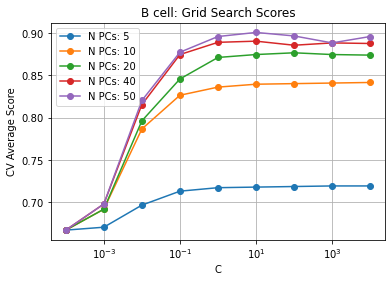

T cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Best parameter (CV score=0.848):
{'logistic__C': 1.0, 'pca__n_components': 40}


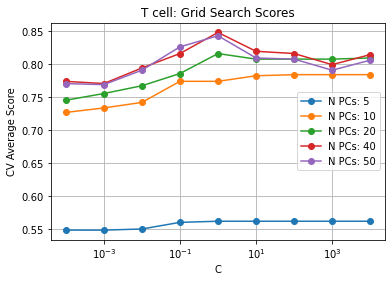

natural killer cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Best parameter (CV score=0.930):
{'logistic__C': 100.0, 'pca__n_components': 20}


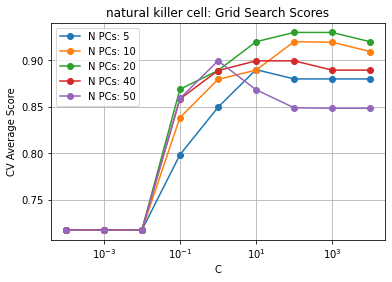

In [47]:
np.random.seed(1234)
    

def run_ml_pipeline(data, pca_n_comps, lr_Cs):
    X = data.X
    y = data.obs['tissue'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    
    lr = LogisticRegression(max_iter=1000)
    pca = PCA()
    scaler = StandardScaler()
#     x = pca.fit_transform(X_train)
#     x = scaler.fit_transform(x)
#     lr.fit(x, y_train)
#     print(lr.score(x, y_train))
#     x = pca.fit_transform(X_test)
#     x = scaler.transform(x)
#     print(lr.score(x, y_test))
    
    pipe = Pipeline(steps=[('pca', pca), ('scaler', scaler), ('logistic', lr)])
    
    
    param_grid = {
        'pca__n_components': pca_n_comps,
        'logistic__C': lr_Cs
    }
#     param_grid = {
#         'pca__n_components': [5, 6],
#         'logistic__C': [1., 10., 100.]
#     }
    cv = GridSearchCV(pipe, param_grid, n_jobs=1, verbose=0)
    cv.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % cv.best_score_)
    print(cv.best_params_)
    return cv

def plot_cv_results(cv, param_1_vals, param_2_vals, param_1_name, param_2_name, title):
    scores_mean = np.array(cv.cv_results_['mean_test_score']).reshape(len(param_1_vals), len(param_2_vals))
    scores_std = np.array(cv.cv_results_['std_test_score']).reshape(len(param_1_vals), len(param_2_vals))
    
    _, ax = plt.subplots(1,1)
    ax.set_xscale('log')
    for idx, val in enumerate(param_2_vals):
        ax.plot(param_1_vals, scores_mean[:, idx], '-o', label=param_2_name + ': ' + str(val))
    ax.set_title(f"{title}: Grid Search Scores")
    ax.set_xlabel(param_1_name)
    ax.set_ylabel('CV Average Score')
    ax.legend()
    ax.grid('on')
    plt.show()

pca_n_comps = [5, 10, 20, 40, 50]
lr_Cs = np.logspace(-4, 4, 9)
for cell_type in adata.obs['cell_ontology_class'].unique():
    print(cell_type)
    ct_subset = adata[adata.obs['cell_ontology_class'] == cell_type]
    cv = run_ml_pipeline(ct_subset, pca_n_comps, lr_Cs)
#     df = pd.DataFrame.from_dict(cv.cv_results_)
    plot_cv_results(cv, lr_Cs, pca_n_comps, "C", "N PCs", cell_type)

[Back to Contents](#Contents)

### Exploration of sparsity vs accuracy tradeoff

In [7]:
def filter_hvg(adata):
    log_normed = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(log_normed)
    adata.var['highly_variable'] = log_normed.var['highly_variable']
    adata.var['dispersions_norm'] = log_normed.var['dispersions_norm']
    highly_variable = adata.var.index[adata.var['highly_variable'] == True]
    return adata[:, highly_variable], highly_variable

# First filter to HVGs
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")
ct_tissue_features = {}

X = adata_all_hvg.X
y = adata_all_hvg.obs['tissue'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)

lr_Cs = np.logspace(-4, 4, 9)
scale = []
C = []
acc = []
sparsity = []
for do_scale in [True, False]:
    for c in lr_Cs:
        lr = LogisticRegression(class_weight='balanced', C=c, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
        if do_scale:
            x = scaler.transform(X_train)
            x_test = scaler.transform(X_test)
        else:
            x = X_train
            x_test = X_test
        lr.fit(x, y_train)
        test_acc = lr.score(x_test, y_test)
        scale.append(do_scale)
        C.append(c)
        acc.append(test_acc)
        coef_sparsity = np.mean(lr.coef_.ravel() == 0) * 100
        sparsity.append(coef_sparsity)
        print(f"test_acc: {test_acc}")


Initial data shape: (9470, 23433)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After hvg shape: (9470, 5109)
	Removed 18324 genes
test_acc: 0.18116554054054054
test_acc: 0.5696790540540541


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7491554054054054


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7892736486486487


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7825168918918919


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7787162162162162


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7791385135135135


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7795608108108109


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.7795608108108109


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.737331081081081


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8137668918918919


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8222128378378378


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8226351351351351


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8226351351351351


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8226351351351351


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8226351351351351


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


test_acc: 0.8230574324324325
test_acc: 0.8226351351351351


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


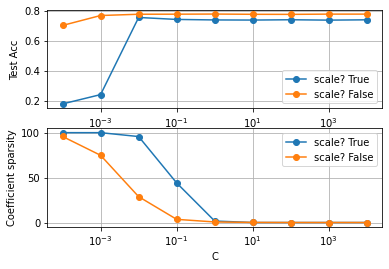

In [10]:
df = pd.DataFrame(data={'do_scale': scale, 'C': C, 'acc': acc, 'sparsity': sparsity})
_, axs = plt.subplots(2,1)
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Test Acc')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Coefficient sparsity')
axs[0].grid('on')
axs[1].grid('on')
for do_scale in [True, False]:
    scale_sub = df[df['do_scale'] == do_scale]
    scale_sub = scale_sub.sort_values('C')
    axs[0].plot(scale_sub['C'], scale_sub['acc'], '-o', label=f"scale? {str(do_scale)}")
    axs[1].plot(scale_sub['C'], scale_sub['sparsity'], '-o', label=f"scale? {str(do_scale)}")
axs[0].legend()
axs[1].legend()
plt.show()

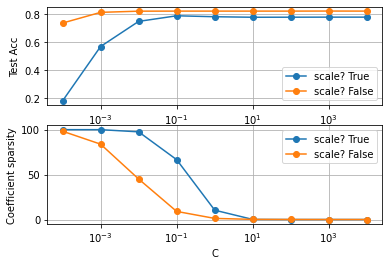

In [8]:
# same as above, but letting it solve for max 500 iters
df = pd.DataFrame(data={'do_scale': scale, 'C': C, 'acc': acc, 'sparsity': sparsity})
_, axs = plt.subplots(2,1)
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Test Acc')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Coefficient sparsity')
axs[0].grid('on')
axs[1].grid('on')
for do_scale in [True, False]:
    scale_sub = df[df['do_scale'] == do_scale]
    scale_sub = scale_sub.sort_values('C')
    axs[0].plot(scale_sub['C'], scale_sub['acc'], '-o', label=f"scale? {str(do_scale)}")
    axs[1].plot(scale_sub['C'], scale_sub['sparsity'], '-o', label=f"scale? {str(do_scale)}")
axs[0].legend()
axs[1].legend()
plt.show()

[Back to Contents](#Contents)

### Simple model fitting

Initial data shape: (9328, 23433)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After hvg shape: (9328, 5127)
	Removed 18306 genes


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.7524299599771298
coef_sparsity: 98.12268383070023


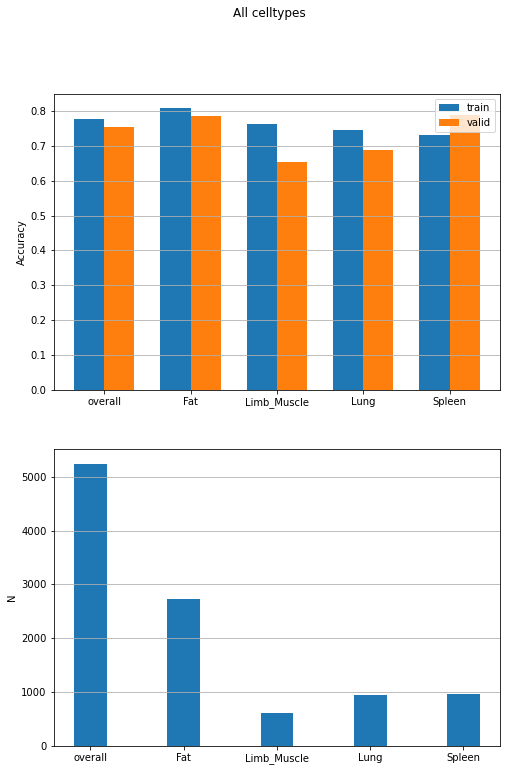

B cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.5484764542936288


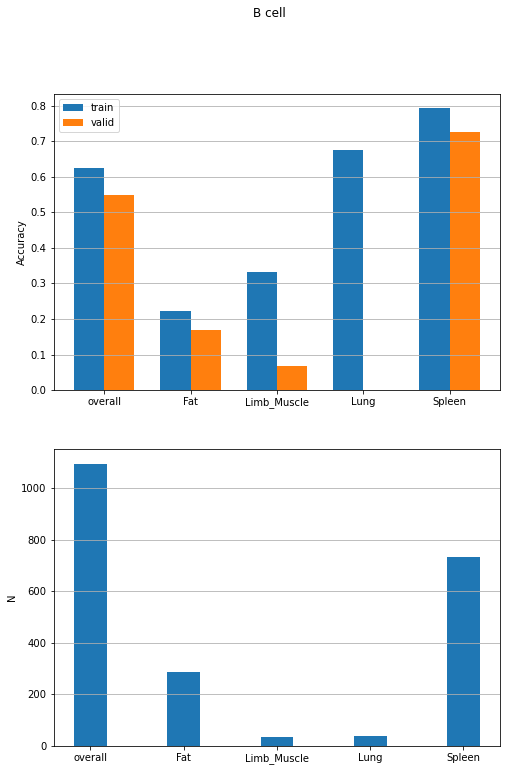

T cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.35664335664335667


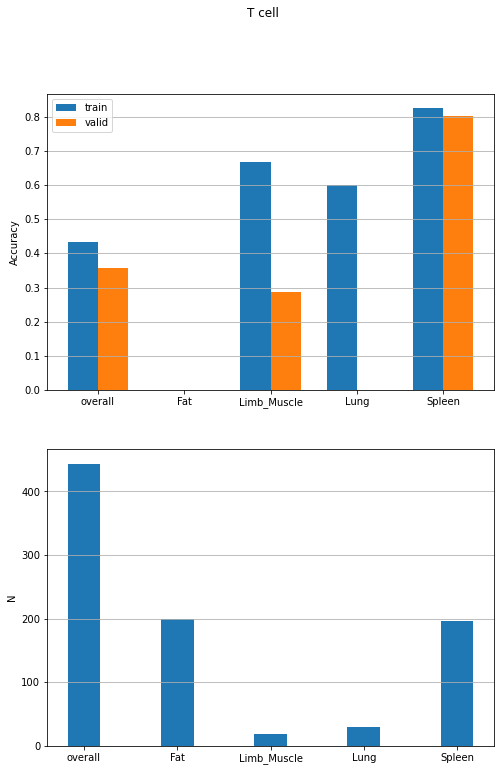

natural killer cell
valid_acc: 0.6818181818181818


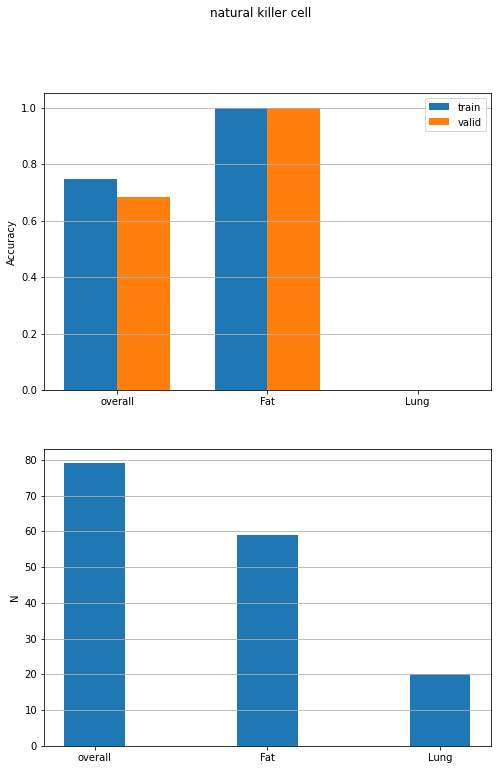

In [41]:
np.random.seed(1234)

def filter_hvg(adata):
    log_normed = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(log_normed)
    adata.var['highly_variable'] = log_normed.var['highly_variable']
    adata.var['dispersions_norm'] = log_normed.var['dispersions_norm']
    highly_variable = adata.var.index[adata.var['highly_variable'] == True]
    return adata[:, highly_variable], highly_variable

def plot_classifier_accuracy(y_train_true, y_train_pred, y_valid_true, y_valid_pred, title=""):
    bars_train = [accuracy_score(y_train_true, y_train_pred)]
    bars_train_n = [len(y_train_true)]
    bars_valid = [accuracy_score(y_valid_true, y_valid_pred)]
    bar_names = ['overall']
    for label in np.unique(y_train_true):
        bar_names.append(label)
        idx = y_train_true == label
        bars_train.append(accuracy_score(y_train_true[idx], y_train_pred[idx]))
        bars_train_n.append(idx.sum())
        idx = y_valid_true == label
        bars_valid.append(accuracy_score(y_valid_true[idx], y_valid_pred[idx]))
    fig, ax = plt.subplots(2, 1, figsize=(8,12))
    x = np.arange(len(bars_train))
    width = 0.35
    ax[0].bar(x-width/2, bars_train, width, label='train')
    ax[0].bar(x+width/2, bars_valid, width, label='valid')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(bar_names)
    ax[0].legend()
    ax[1].bar(bar_names, bars_train_n, width)
    ax[1].set_ylabel('N')
    ax[0].grid('on', axis='y')
    ax[1].grid('on', axis='y')
    fig.suptitle(title)
    plt.show()

# First filter to HVGs
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")


X = adata_all_hvg.X
y = adata_all_hvg.obs['tissue'].to_numpy()
y_celltype = adata_all_hvg.obs['cell_ontology_class'].to_numpy()

X_train, X_test, y_train, y_test, y_ct_train, y_ct_test= train_test_split(X, y, y_celltype, stratify=y)
X_train, X_valid, y_train, y_valid, y_ct_train, y_ct_valid = train_test_split(X_train, y_train, y_ct_train, stratify=y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Overall tissue classifier:
lr = LogisticRegression(class_weight='balanced', C=1e-2, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
lr.fit(X_train, y_train)
valid_acc = lr.score(X_valid, y_valid)
coef_sparsity = np.mean(lr.coef_.ravel() == 0) * 100
print(f"valid_acc: {valid_acc}")
print(f"coef_sparsity: {coef_sparsity}")
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
plot_classifier_accuracy(y_train, y_train_pred, y_valid, y_valid_pred, "All celltypes")

celltypes = ['B cell', 'T cell', 'natural killer cell']
models = []
for ct in celltypes:
    print(ct)
    train_idx = y_ct_train == ct
    ct_X_train = X_train[train_idx]
    ct_y_train = y_train[train_idx]
    valid_idx = y_ct_valid == ct
    ct_X_valid = X_valid[valid_idx]
    ct_y_valid = y_valid[valid_idx]
    
    ct_lr = LogisticRegression(class_weight='balanced', C=1e-2, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
    ct_lr.fit(ct_X_train, ct_y_train)
    models.append(ct_lr)
    ct_valid_acc = ct_lr.score(ct_X_valid, ct_y_valid)
    y_train_pred = ct_lr.predict(ct_X_train)
    y_valid_pred = ct_lr.predict(ct_X_valid)
    
    print(f"valid_acc: {ct_valid_acc}")
    
    plot_classifier_accuracy(ct_y_train, y_train_pred, ct_y_valid, y_valid_pred, ct)

5127
always zero: 4705


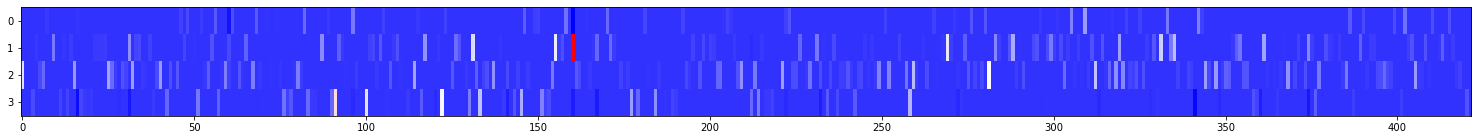

Lung
(4, 5127)
4


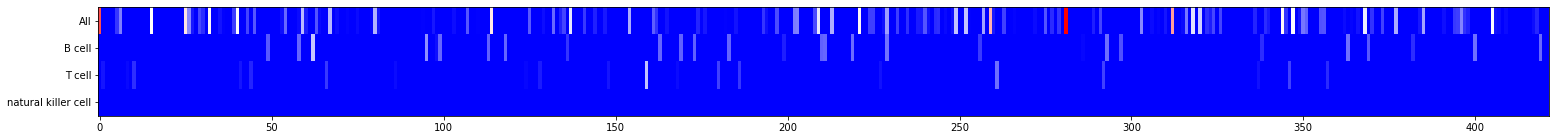

Limb_Muscle
(3, 5127)
3


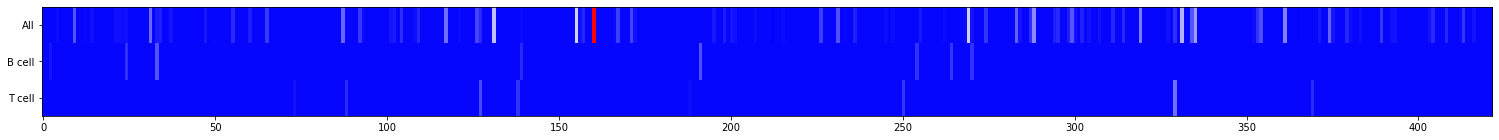

Fat
(4, 5127)
4


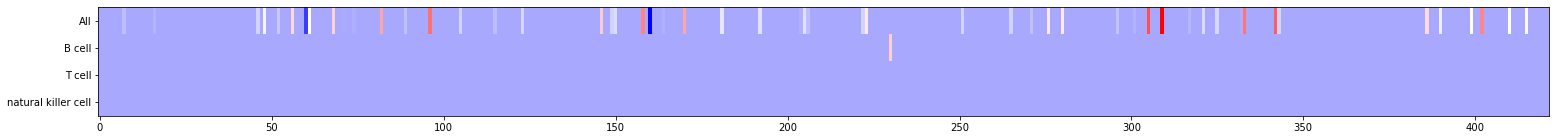

Spleen
(3, 5127)
3


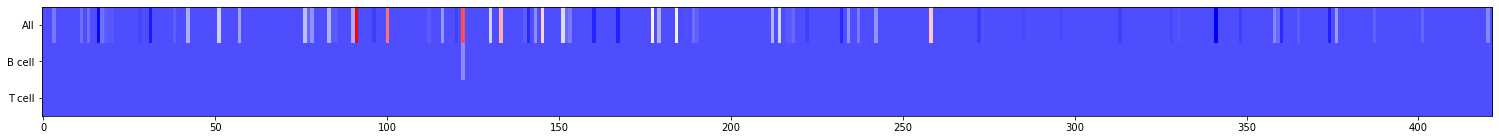

In [42]:
def consolidate_non_zero_features(coefs):
    print(coefs.shape[1])
    always_zero = np.ones(coefs.shape[1])
    zeros = (coefs == 0).sum(axis=0)
    always_zeros = zeros == coefs.shape[0]
    print(f"always zero: {always_zeros.sum()}")
    return ~always_zeros

all_coefs = np.concatenate([lr.coef_] + [m.coef_ for m in models])
non_zero_selector = consolidate_non_zero_features(all_coefs)

plt.figure(figsize=(26, 2))
plt.imshow(lr.coef_[:, non_zero_selector], cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

for tissue in ['Lung', 'Limb_Muscle', 'Fat', 'Spleen']:
    print(tissue)
    coefs = None
    ct = []
    
    idx = np.where(lr.classes_ == tissue)[0][0]
    coefs = lr.coef_[idx]
    ct.append('All')
    
    for cell_type, model in zip(celltypes, models):
        idx = np.where(model.classes_ == tissue)[0]
        if len(idx) == 0:
            continue
        idx = idx[0]
        if len(model.classes_) == 2:
            cur_coefs = model.coef_[0, :]
        else:
            cur_coefs = model.coef_[idx]
        if coefs is None:
            coefs = cur_coefs
        else:
            coefs = np.vstack((coefs, cur_coefs))
        ct.append(cell_type)
    
    print(coefs.shape)
    print(len(ct))
    _, ax = plt.subplots(1, 1, figsize=(26, 2))
    ax.imshow(coefs[:, non_zero_selector], cmap='bwr', interpolation='nearest', aspect='auto')
    ax.set_yticks(np.arange(len(ct)))
    ax.set_yticklabels(ct)
    plt.show()

Initial data shape: (9470, 23433)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After hvg shape: (9470, 5109)
	Removed 18324 genes


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.777027027027027
coef_sparsity: 69.68095517713839


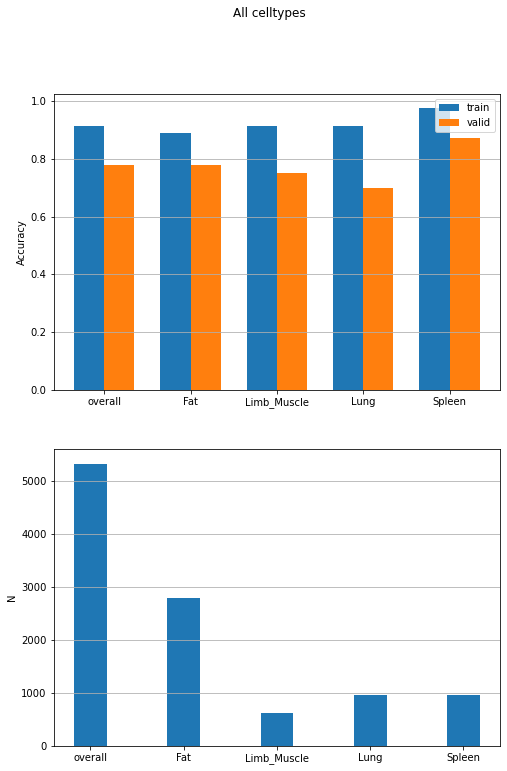

B cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.5423280423280423


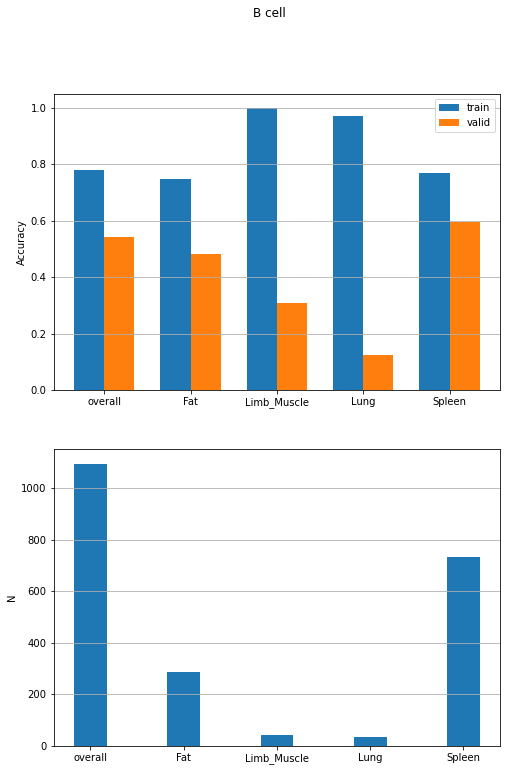

T cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.51875


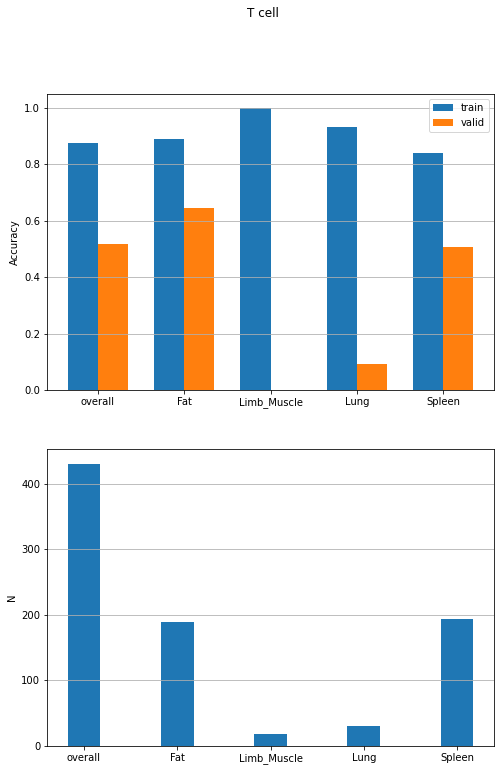

natural killer cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.7272727272727273


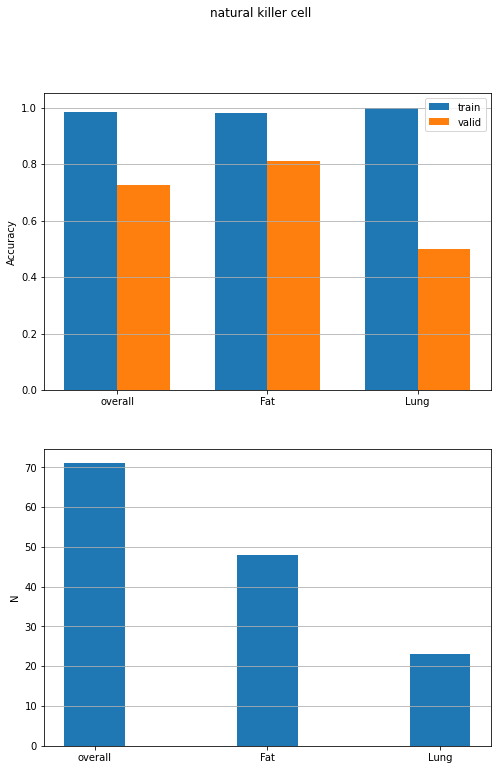

In [59]:
np.random.seed(1234)

from sklearn.metrics import accuracy_score

def filter_hvg(adata):
    log_normed = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(log_normed)
    adata.var['highly_variable'] = log_normed.var['highly_variable']
    adata.var['dispersions_norm'] = log_normed.var['dispersions_norm']
    highly_variable = adata.var.index[adata.var['highly_variable'] == True]
    return adata[:, highly_variable], highly_variable

def plot_classifier_accuracy(y_train_true, y_train_pred, y_valid_true, y_valid_pred, title=""):
    bars_train = [accuracy_score(y_train_true, y_train_pred)]
    bars_train_n = [len(y_train_true)]
    bars_valid = [accuracy_score(y_valid_true, y_valid_pred)]
    bar_names = ['overall']
    for label in np.unique(y_train_true):
        bar_names.append(label)
        idx = y_train_true == label
        bars_train.append(accuracy_score(y_train_true[idx], y_train_pred[idx]))
        bars_train_n.append(idx.sum())
        idx = y_valid_true == label
        bars_valid.append(accuracy_score(y_valid_true[idx], y_valid_pred[idx]))
    fig, ax = plt.subplots(2, 1, figsize=(8,12))
    x = np.arange(len(bars_train))
    width = 0.35
    ax[0].bar(x-width/2, bars_train, width, label='train')
    ax[0].bar(x+width/2, bars_valid, width, label='valid')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(bar_names)
    ax[0].legend()
    ax[1].bar(bar_names, bars_train_n, width)
    ax[1].set_ylabel('N')
    ax[0].grid('on', axis='y')
    ax[1].grid('on', axis='y')
    fig.suptitle(title)
    plt.show()

# First filter to HVGs
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")


X = adata_all_hvg.X
y = adata_all_hvg.obs['tissue'].to_numpy()
y_celltype = adata_all_hvg.obs['cell_ontology_class'].to_numpy()

X_train, X_test, y_train, y_test, y_ct_train, y_ct_test= train_test_split(X, y, y_celltype, stratify=y)
X_train, X_valid, y_train, y_valid, y_ct_train, y_ct_valid = train_test_split(X_train, y_train, y_ct_train, stratify=y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Overall tissue classifier:
lr = LogisticRegression(class_weight='balanced', C=1e-1, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
lr.fit(X_train, y_train)
valid_acc = lr.score(X_valid, y_valid)
coef_sparsity = np.mean(lr.coef_.ravel() == 0) * 100
print(f"valid_acc: {valid_acc}")
print(f"coef_sparsity: {coef_sparsity}")
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
plot_classifier_accuracy(y_train, y_train_pred, y_valid, y_valid_pred, "All celltypes")

celltypes = ['B cell', 'T cell', 'natural killer cell']
models = []
for ct in celltypes:
    print(ct)
    train_idx = y_ct_train == ct
    ct_X_train = X_train[train_idx]
    ct_y_train = y_train[train_idx]
    valid_idx = y_ct_valid == ct
    ct_X_valid = X_valid[valid_idx]
    ct_y_valid = y_valid[valid_idx]
    
    ct_lr = LogisticRegression(class_weight='balanced', C=1e-1, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
    ct_lr.fit(ct_X_train, ct_y_train)
    models.append(ct_lr)
    ct_valid_acc = ct_lr.score(ct_X_valid, ct_y_valid)
    y_train_pred = ct_lr.predict(ct_X_train)
    y_valid_pred = ct_lr.predict(ct_X_valid)
    
    print(f"valid_acc: {ct_valid_acc}")
    
    plot_classifier_accuracy(ct_y_train, y_train_pred, ct_y_valid, y_valid_pred, ct)

5109
always zero: 1640


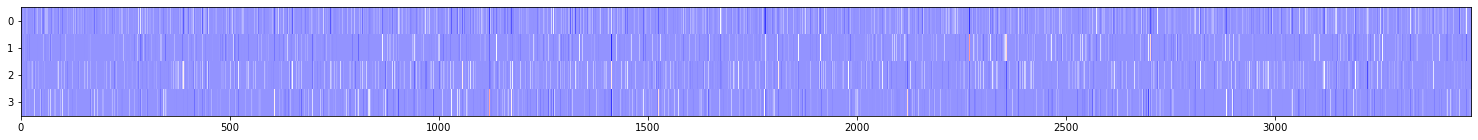

Lung
(4, 5109)
4


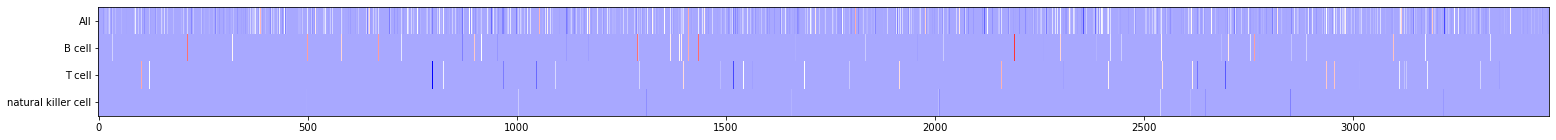

Limb_Muscle
(3, 5109)
3


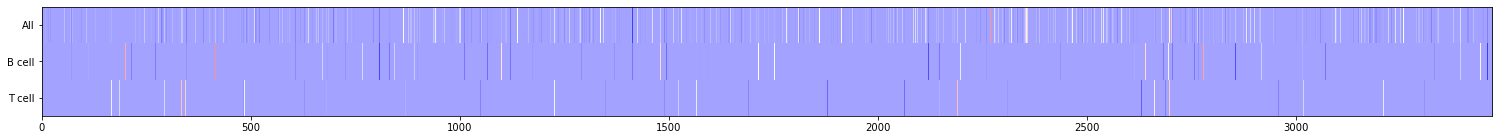

Fat
(4, 5109)
4


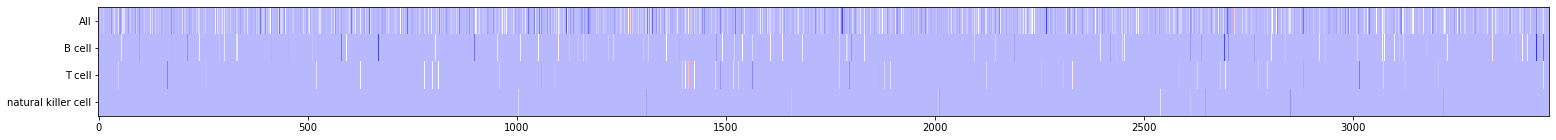

Spleen
(3, 5109)
3


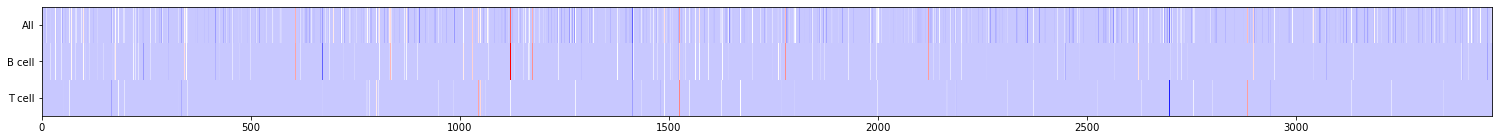

In [62]:
def consolidate_non_zero_features(coefs):
    print(coefs.shape[1])
    always_zero = np.ones(coefs.shape[1])
    zeros = (coefs == 0).sum(axis=0)
    always_zeros = zeros == coefs.shape[0]
    print(f"always zero: {always_zeros.sum()}")
    return ~always_zeros

all_coefs = np.concatenate([lr.coef_] + [m.coef_ for m in models])
non_zero_selector = consolidate_non_zero_features(all_coefs)

plt.figure(figsize=(26, 2))
plt.imshow(lr.coef_[:, non_zero_selector], cmap='bwr', interpolation='nearest', aspect='auto')
plt.show()

for tissue in ['Lung', 'Limb_Muscle', 'Fat', 'Spleen']:
    print(tissue)
    coefs = None
    ct = []
    
    idx = np.where(lr.classes_ == tissue)[0][0]
    coefs = lr.coef_[idx]
    ct.append('All')
    
    for cell_type, model in zip(celltypes, models):
        idx = np.where(model.classes_ == tissue)[0]
        if len(idx) == 0:
            continue
        idx = idx[0]
        if len(model.classes_) == 2:
            cur_coefs = model.coef_[0, :]
        else:
            cur_coefs = model.coef_[idx]
        if coefs is None:
            coefs = cur_coefs
        else:
            coefs = np.vstack((coefs, cur_coefs))
        ct.append(cell_type)
    
    print(coefs.shape)
    print(len(ct))
    _, ax = plt.subplots(1, 1, figsize=(26, 2))
    ax.imshow(coefs[:, non_zero_selector], cmap='bwr', interpolation='nearest', aspect='auto')
    ax.set_yticks(np.arange(len(ct)))
    ax.set_yticklabels(ct)
    plt.show()

[Back to Contents](#Contents)

## Tree-based

[Back to Contents](#Contents)

# DE Analysis

## Preprocessing

In [92]:
# Load fresh data
adata_all = load_data(annotations, ['Lung', 'Limb_Muscle', 'Fat', 'Spleen'])
nans = adata_all.obs['cell_ontology_class'].isna()
adata_all = adata_all[~nans]

data/tabula_muris/FACS/Lung-counts.csv
(1716, 23433)
(1716, 23433)
data/tabula_muris/FACS/Limb_Muscle-counts.csv
(1090, 23433)
(1090, 23433)
data/tabula_muris/FACS/Fat-counts.csv
(4967, 23433)
(4967, 23433)
data/tabula_muris/FACS/Spleen-counts.csv
(1697, 23433)
(1697, 23433)


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


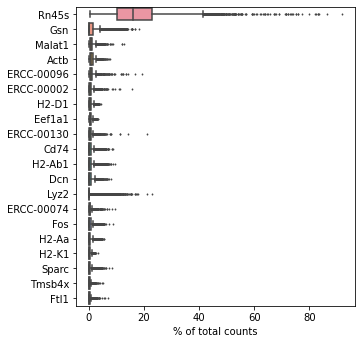

In [93]:
sc.pl.highest_expr_genes(adata_all, n_top=20)

In [94]:
sc.pp.filter_cells(adata_all, min_genes=200)
sc.pp.filter_genes(adata_all, min_cells=3)

In [95]:
sc.pp.calculate_qc_metrics(adata_all, percent_top=None, log1p=False, inplace=True)

... storing 'Neurog3>0_raw' as categorical
... storing 'Neurog3>0_scaled' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subsetA' as categorical
... storing 'subsetB' as categorical
... storing 'subsetC' as categorical
... storing 'subsetD' as categorical
... storing 'subsetE' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_

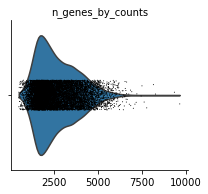

In [96]:
sc.pl.violin(adata_all, ['n_genes_by_counts'], multi_panel=True)

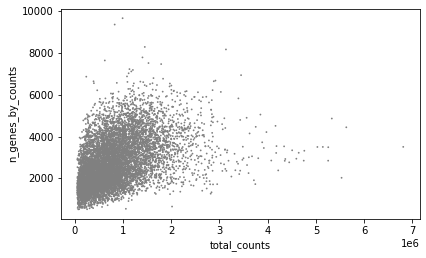

In [97]:
sc.pl.scatter(adata_all, x='total_counts', y='n_genes_by_counts')

In [98]:
print(adata_all.shape)
adata_all = adata_all[adata_all.obs.n_genes_by_counts < 7500, :]
print(adata_all.shape)

(9328, 20005)
(9321, 20005)


In [99]:
sc.pp.normalize_total(adata_all)

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [100]:
sc.pp.log1p(adata_all)

In [101]:
sc.pp.highly_variable_genes(adata_all)

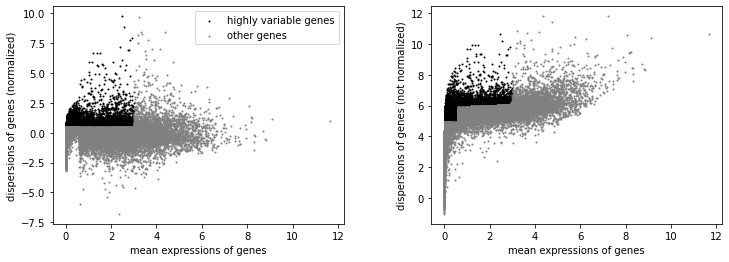

In [102]:
sc.pl.highly_variable_genes(adata_all)

In [103]:
adata_all.raw = adata_all

In [104]:
adata_all = adata_all[:, adata_all.var.highly_variable]

In [105]:
adata_all.shape

(9321, 4296)

In [106]:
sc.pp.regress_out(adata_all, ['total_counts'])

In [107]:
sc.pp.scale(adata_all)

In [108]:
sc.tl.pca(adata_all)

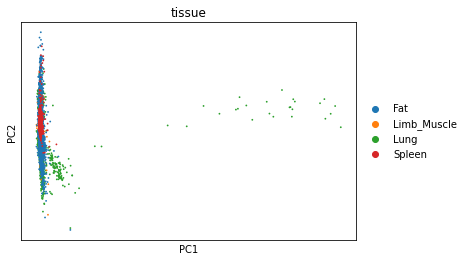

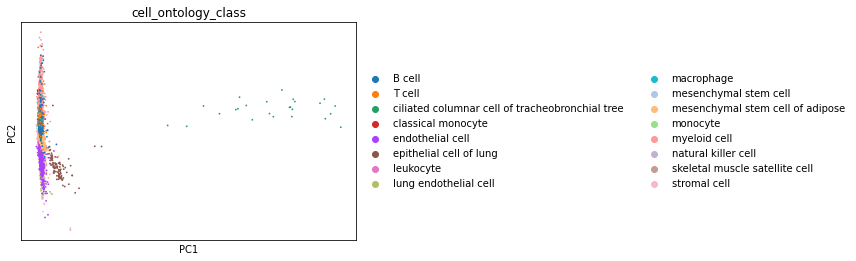

In [111]:
sc.pl.pca(adata_all, color='tissue')
sc.pl.pca(adata_all, color='cell_ontology_class')

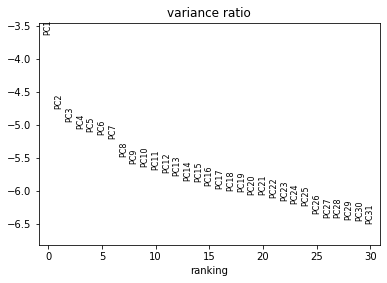

In [112]:
sc.pl.pca_variance_ratio(adata_all, log=True)

In [113]:
sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=30)

In [114]:
sc.tl.umap(adata_all)

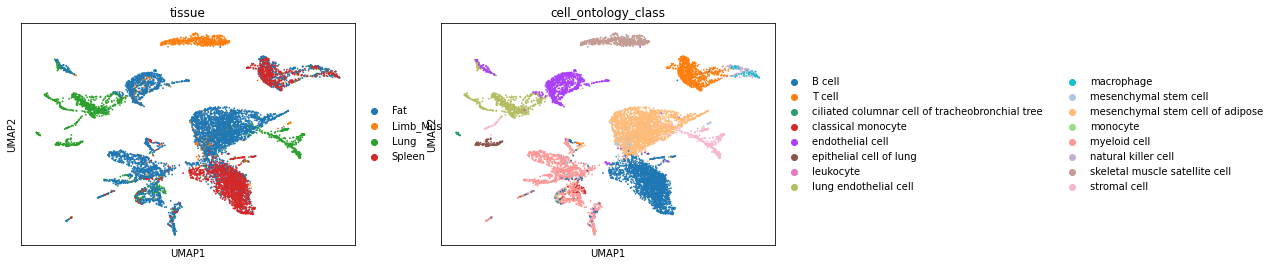

In [115]:
sc.pl.umap(adata_all, color=['tissue', 'cell_ontology_class'])

[Back to Contents](#Contents)

## Grouped by Cell Type

In [116]:
sc.tl.rank_genes_groups(adata_all, groupby='cell_ontology_class', n_genes=adata_ct_subset.shape[1], method='wilcoxon')

### Inspect expression of the top 10 genes for each Cell Type

categories: B cell, T cell, ciliated columnar cell of tracheobronchial tree, etc.
var_group_labels: B cell, T cell, natural killer cell


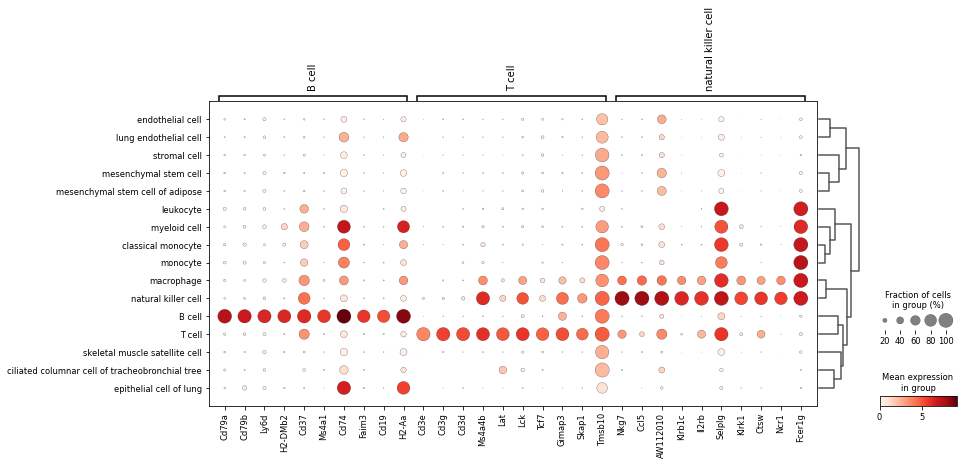

In [117]:
sc.pl.rank_genes_groups_dotplot(adata_all, n_genes=10, groups=['B cell', 'T cell', 'natural killer cell'])

[Back to Contents](#Contents)

### Inspect Log-fold changes, only genes with log-fold change of at least 3 for each cell type

In [120]:
dedf = sc.get.rank_genes_groups_df(adata_all, group="natural killer cell")

In [121]:
dedf

,scores,names,logfoldchanges,pvals,pvals_adj
0,19.483046,Nkg7,12.969664,1.529090e-84,3.058945e-80
1,19.437698,Ccl5,13.576571,3.704217e-84,3.705143e-80
2,19.072701,AW112010,8.803756,4.257331e-81,2.838930e-77
3,18.960407,Klrb1c,12.825762,3.623258e-80,1.812082e-76
4,18.588928,Il2rb,10.469827,3.949887e-77,1.580350e-73
...,...,...,...,...,...
5104,-0.015051,Rimbp2,-20.030617,9.879917e-01,9.985789e-01
5105,-0.015051,Itln1,-20.060671,9.879917e-01,9.985789e-01
5106,-0.015051,Mrgpra4,-21.292500,9.879917e-01,9.985789e-01
5107,-0.015051,Ces2f,-20.144165,9.879917e-01,9.985789e-01


categories: B cell, T cell, ciliated columnar cell of tracheobronchial tree, etc.
var_group_labels: B cell, T cell, natural killer cell


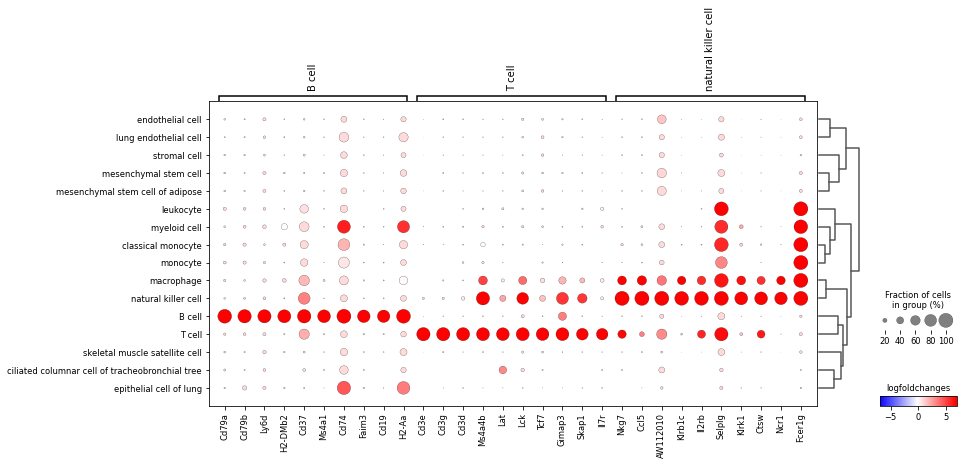

In [122]:
sc.pl.rank_genes_groups_dotplot(adata_all, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', groups=['B cell', 'T cell', 'natural killer cell'])

[Back to Contents](#Contents)

## Grouped by Tissue

In [123]:
sc.tl.rank_genes_groups(adata_all, groupby='tissue', n_genes=adata_ct_subset.shape[1], method='wilcoxon')

### Inspect expression of the top 10 genes for each Tissue Type

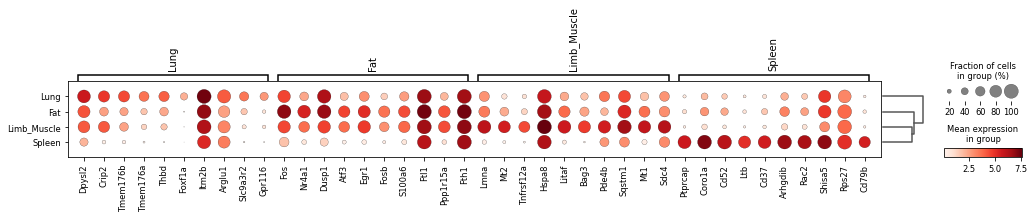

In [124]:
sc.pl.rank_genes_groups_dotplot(adata_all, n_genes=10)

[Back to Contents](#Contents)

### Inspect Log-fold changes, only genes with log-fold change of at least 3 for each Tissue Type

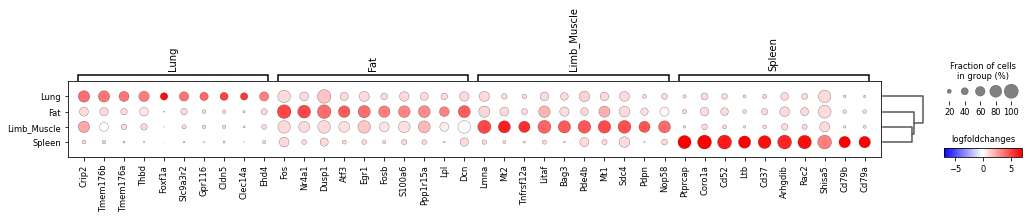

In [125]:
sc.pl.rank_genes_groups_dotplot(adata_all, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

[Back to Contents](#Contents)

## First subset to tissues, then group by cell type

### Inspect Log-fold changes, only genes with log-fold change of at least 3 for each cell type

In [120]:
dedf = sc.get.rank_genes_groups_df(adata_all, group="natural killer cell")

In [121]:
dedf

,scores,names,logfoldchanges,pvals,pvals_adj
0,19.483046,Nkg7,12.969664,1.529090e-84,3.058945e-80
1,19.437698,Ccl5,13.576571,3.704217e-84,3.705143e-80
2,19.072701,AW112010,8.803756,4.257331e-81,2.838930e-77
3,18.960407,Klrb1c,12.825762,3.623258e-80,1.812082e-76
4,18.588928,Il2rb,10.469827,3.949887e-77,1.580350e-73
...,...,...,...,...,...
5104,-0.015051,Rimbp2,-20.030617,9.879917e-01,9.985789e-01
5105,-0.015051,Itln1,-20.060671,9.879917e-01,9.985789e-01
5106,-0.015051,Mrgpra4,-21.292500,9.879917e-01,9.985789e-01
5107,-0.015051,Ces2f,-20.144165,9.879917e-01,9.985789e-01


categories: B cell, T cell, ciliated columnar cell of tracheobronchial tree, etc.
var_group_labels: B cell, T cell, natural killer cell


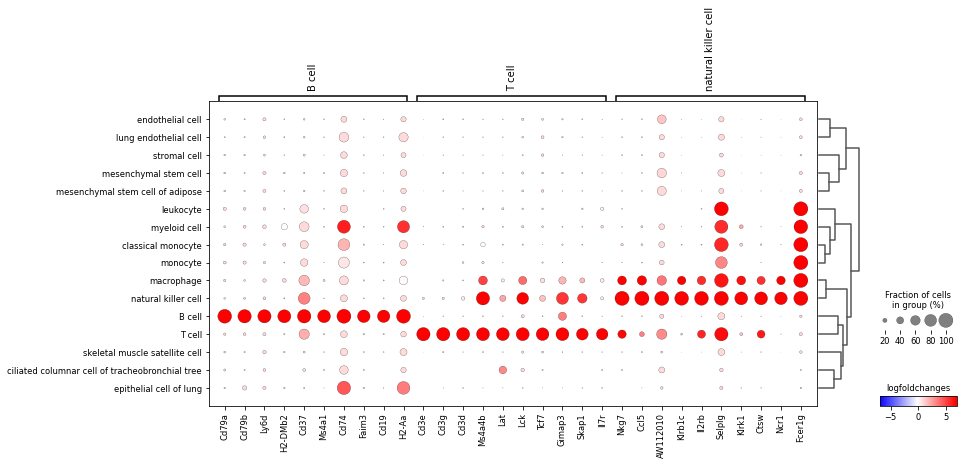

In [122]:
sc.pl.rank_genes_groups_dotplot(adata_all, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', groups=['B cell', 'T cell', 'natural killer cell'])

In [25]:
ct_adatas = {}
for ct in ['B cell', 'T cell', 'natural killer cell']:
    adata_ct_subset = adata_all_hvg[adata_all_hvg.obs['cell_ontology_class'] == ct]
    # sc.tl.rank_genes_groups(adata_ct_subset, groupby='tissue', method='t-test')
    sc.tl.rank_genes_groups(adata_ct_subset, groupby='tissue', n_genes=adata_ct_subset.shape[1], method='wilcoxon')
    ct_adatas[ct] = adata_ct_subset# .uns['rank_genes_groups']

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copyin

B cell


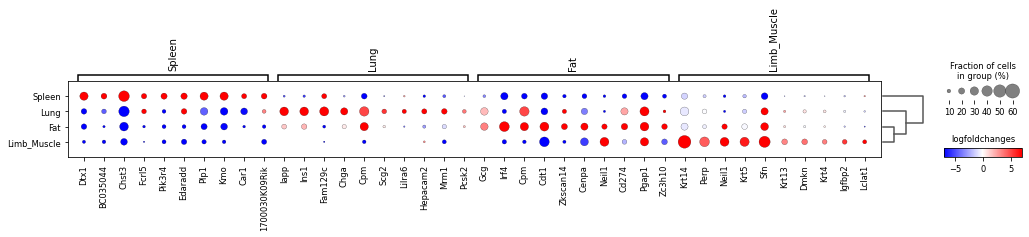

T cell


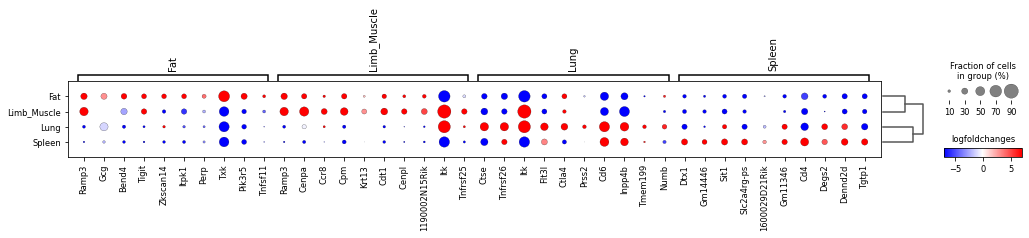

natural killer cell


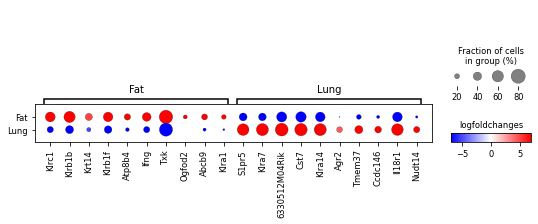

In [28]:
for ct, adata in ct_adatas.items():
    print(ct)
    sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

In [58]:
de_ct_subset_for_each_tiss = defaultdict(dict)
for ct, tissue_marker_info in markers.items():
    print(f"##### {ct} #####")
    for tissue in tissue_marker_info['names'].dtype.names:
        print(tissue)
        adj_pvals = tissue_marker_info['pvals_adj'][tissue]
        fc = tissue_marker_info['logfoldchanges'][tissue]
        idx = (adj_pvals < 0.1) & (fc > 0)
        filtered_markers = tissue_marker_info['names'][tissue][idx]
        print(len(filtered_markers))
        print()
        print()
        de_ct_subset_for_each_tiss[ct][tissue] = filtered_markers

##### B cell #####
Fat
3


Limb_Muscle
2


Lung
0


Spleen
30


##### T cell #####
Fat
1


Limb_Muscle
0


Lung
0


Spleen
2


##### natural killer cell #####
Fat
0


Lung
0




In [61]:
for cell_type, model in zip(celltypes, models):
    de = de_ct_subset_for_each_tiss[cell_type]
    if len(model.classes_) == 2:
        pass
    else:
        for i, tiss in enumerate(model.classes_):
            nz = np.nonzero(model.coef_[i])[0]
            nz = set(adata_all_hvg.var_names[nz])
            de_

['Insm2', 'Utf1', 'Cenpa']
['Casp7', 'Hepacam2', 'Qrsl1']
['Casp7', 'Samd10', 'Vmn2r17']
['Hus1b', 'Rgs13', 'Syngr3']
['B3galt5', 'B930007M17Rik', 'Dock3']
['Als2cl', 'Prkcq', '1700056E22Rik']
['Dock3', '1700001G11Rik', 'Kifc1']
['B930007M17Rik', 'Hist1h4j', 'BC147527']


[Back to Contents](#Contents)

Initial data shape: (9328, 23433)


Trying to set attribute `.var` of view, copying.
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After hvg shape: (9328, 5127)
	Removed 18306 genes


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.7753001715265866
coef_sparsity: 69.85566608152915


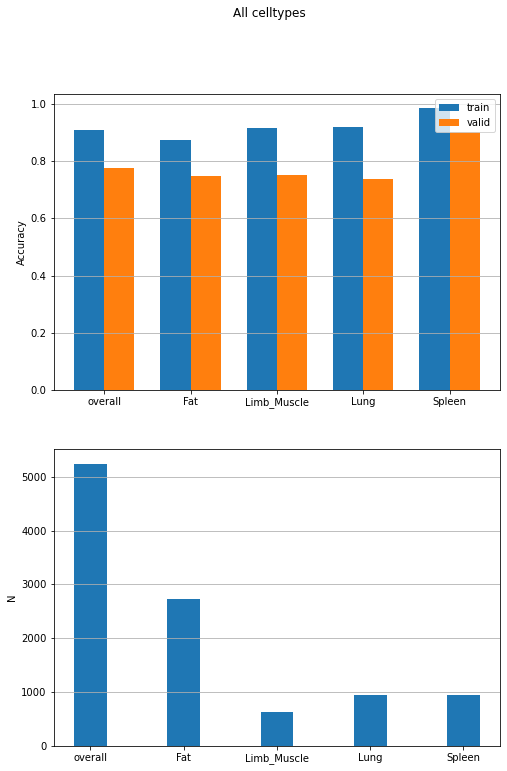

B cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.5137362637362637


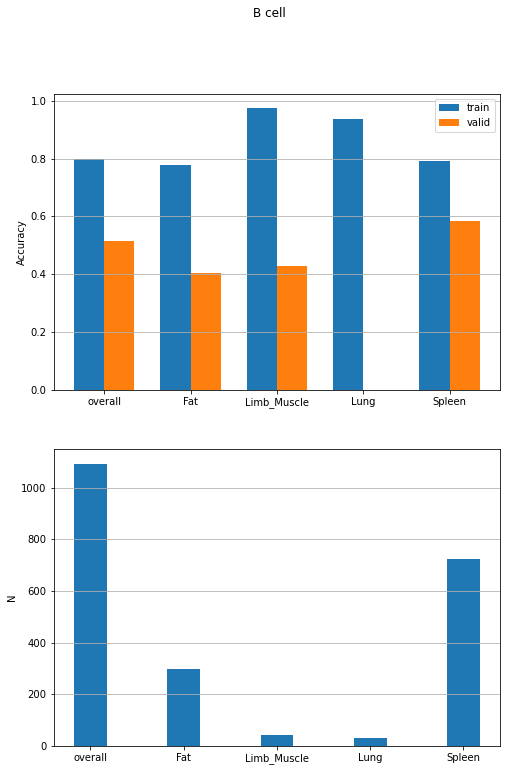

T cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.5570469798657718


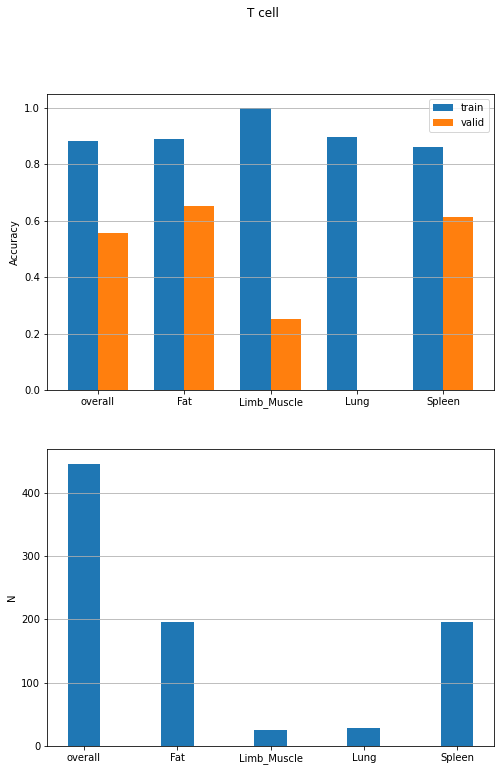

natural killer cell


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


valid_acc: 0.64


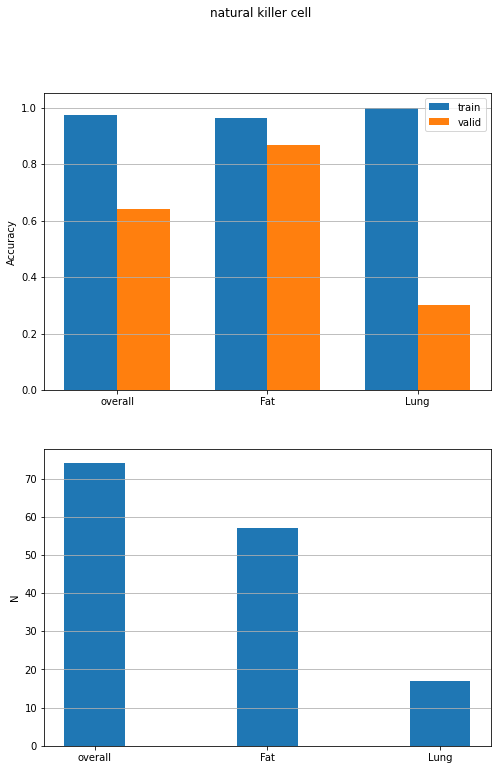

In [31]:
np.random.seed(1234)

from sklearn.metrics import accuracy_score

def filter_hvg(adata):
    log_normed = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(log_normed)
    adata.var['highly_variable'] = log_normed.var['highly_variable']
    adata.var['dispersions_norm'] = log_normed.var['dispersions_norm']
    highly_variable = adata.var.index[adata.var['highly_variable'] == True]
    return adata[:, highly_variable], highly_variable

def plot_classifier_accuracy(y_train_true, y_train_pred, y_valid_true, y_valid_pred, title=""):
    bars_train = [accuracy_score(y_train_true, y_train_pred)]
    bars_train_n = [len(y_train_true)]
    bars_valid = [accuracy_score(y_valid_true, y_valid_pred)]
    bar_names = ['overall']
    for label in np.unique(y_train_true):
        bar_names.append(label)
        idx = y_train_true == label
        bars_train.append(accuracy_score(y_train_true[idx], y_train_pred[idx]))
        bars_train_n.append(idx.sum())
        idx = y_valid_true == label
        bars_valid.append(accuracy_score(y_valid_true[idx], y_valid_pred[idx]))
    fig, ax = plt.subplots(2, 1, figsize=(8,12))
    x = np.arange(len(bars_train))
    width = 0.35
    ax[0].bar(x-width/2, bars_train, width, label='train')
    ax[0].bar(x+width/2, bars_valid, width, label='valid')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(bar_names)
    ax[0].legend()
    ax[1].bar(bar_names, bars_train_n, width)
    ax[1].set_ylabel('N')
    ax[0].grid('on', axis='y')
    ax[1].grid('on', axis='y')
    fig.suptitle(title)
    plt.show()

# First filter to HVGs
print(f"Initial data shape: {adata_all.shape}")
adata_all_hvg, hvg_genes = filter_hvg(adata_all)
print(f"After hvg shape: {adata_all_hvg.shape}")
adata_hvg = adata[:, hvg_genes]
print(f"\tRemoved {adata.shape[1] - adata_hvg.shape[1]} genes")


X = adata_all_hvg.X
y_tissue = adata_all_hvg.obs['tissue'].to_numpy()
y_celltype = adata_all_hvg.obs['cell_ontology_class'].to_numpy()

X_train, X_test, y_train, y_test, y_ct_train, y_ct_test = train_test_split(X, y_tissue, y_celltype, stratify=y_celltype)
X_train, X_valid, y_train, y_valid, y_ct_train, y_ct_valid = train_test_split(X_train, y_train, y_ct_train, stratify=y_ct_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Overall tissue classifier:
lr = LogisticRegression(class_weight='balanced', C=1e-1, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
lr.fit(X_train, y_train)
valid_acc = lr.score(X_valid, y_valid)
coef_sparsity = np.mean(lr.coef_.ravel() == 0) * 100
print(f"valid_acc: {valid_acc}")
print(f"coef_sparsity: {coef_sparsity}")
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
plot_classifier_accuracy(y_train, y_train_pred, y_valid, y_valid_pred, "All celltypes")

celltypes = ['B cell', 'T cell', 'natural killer cell']
models = []
for ct in celltypes:
    print(ct)
    train_idx = y_ct_train == ct
    ct_X_train = X_train[train_idx]
    ct_y_train = y_train[train_idx]
    valid_idx = y_ct_valid == ct
    ct_X_valid = X_valid[valid_idx]
    ct_y_valid = y_valid[valid_idx]
    
    ct_lr = LogisticRegression(class_weight='balanced', C=1e-1, penalty='l1', multi_class='multinomial', solver='saga', verbose=0, max_iter=500)
    ct_lr.fit(ct_X_train, ct_y_train)
    models.append(ct_lr)
    ct_valid_acc = ct_lr.score(ct_X_valid, ct_y_valid)
    y_train_pred = ct_lr.predict(ct_X_train)
    y_valid_pred = ct_lr.predict(ct_X_valid)
    
    print(f"valid_acc: {ct_valid_acc}")
    
    plot_classifier_accuracy(ct_y_train, y_train_pred, ct_y_valid, y_valid_pred, ct)

5109
always zero: 4774


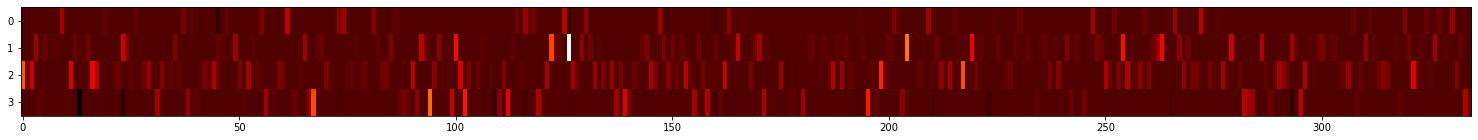

In [28]:
def consolidate_non_zero_features(coefs, names):
    print(coefs.shape[1])
    always_zero = np.ones(coefs.shape[1])
    zeros = (coefs == 0).sum(axis=0)
    always_zeros = zeros == coefs.shape[0]
    print(f"always zero: {always_zeros.sum()}")
    names = names[~always_zeros]
    coefs = coefs[:, ~always_zeros]
    return coefs, names


coefs, gene_names = consolidate_non_zero_features(lr.coef_, adata_all_hvg.var_names)
plt.figure(figsize=(26, 2))
plt.imshow(coefs, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()


['B cell', 'T cell', 'natural killer cell']

for cell_type in adata_hvg.obs['cell_ontology_class'].unique():
    print(cell_type)
    ct_subset = adata_hvg[adata_hvg.obs['cell_ontology_class'] == cell_type]
    X = ct_subset.X
    y = ct_subset.obs['tissue'].to_numpy()
    lr, test_acc, tissue_features = select_features_lr(X, y, ct_subset.var_names, 1e-2)
    ct_tissue_features[cell_type] = tissue_features

Index(['K21.MAA000526.3_9_M.1.1', 'B21.MAA000526.3_9_M.1.1',
       'M21.MAA000526.3_9_M.1.1', 'J21.MAA000526.3_9_M.1.1',
       'A21.MAA000526.3_9_M.1.1', 'G21.MAA000526.3_9_M.1.1',
       'D21.MAA000526.3_9_M.1.1', 'P21.MAA000526.3_9_M.1.1',
       'L21.MAA000526.3_9_M.1.1', 'O22.MAA000526.3_9_M.1.1',
       ...
       'D9.B001750.3_38_F.1.1', 'E20.B001750.3_38_F.1.1',
       'G4.B001750.3_38_F.1.1', 'H10.B001750.3_38_F.1.1',
       'I18.B001750.3_38_F.1.1', 'K4.B001750.3_38_F.1.1',
       'L10.B001750.3_38_F.1.1', 'M16.B001750.3_38_F.1.1',
       'N18.B001750.3_38_F.1.1', 'P1.B001750.3_38_F.1.1'],
      dtype='object', length=2869)

## Find initial, candidate markers using DE analysis

In [14]:
def get_common_markers(de, celltypes):
    # Find markers for each celltypes that are common amongst all datasets
    _celltypes = []
    number_of_markers = []
    set_type = []
    # include = "sig100"
    include = "top100"
    ct_common_markers = {}
    ct_all_markers = {}
    for ct in celltypes:
        print(ct)
        common_markers = None
        all_markers = None
        for i, tissue in enumerate(de.keys()):
            if ct not in de[tissue]['names'].dtype.names:
                continue
            if include == "top100":
                curr_markers = de[tissue]['names'][ct][:100]
            elif include == "sig100":
                adj_pvals = de[tissue]['pvals_adj'][ct]
                idx = adj_pvals < 0.05
                sig = de[tissue]['names'][ct][idx]
                curr_markers = sig[:100]
            if common_markers is None:
                common_markers = set(curr_markers)
                all_markers = common_markers.copy()
            else:
                common_markers &= set(curr_markers)
                all_markers |= set(curr_markers)
        _celltypes.extend([ct] * 2)
        number_of_markers.extend([len(common_markers), len(all_markers)])
        set_type.extend(['intersect', 'union'])
        print(f"{ct} ({len(common_markers)}):\n{common_markers}")
        ct_common_markers[ct] = common_markers
        ct_all_markers[ct] = all_markers
    df = pd.DataFrame({'Cell type': _celltypes, '# of markers': number_of_markers, 'Markers': set_type})
    g = sns.barplot(x='Cell type', y='# of markers', hue='Markers', data=df, hue_order=['intersect', 'union'], ci=None)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    #ax=g.ax #annotate axis = seaborn axis
    def annotateBars(row, ax): 
        for p in ax.patches:
            ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 20),
                        textcoords='offset points')
    _ = df.apply(annotateBars, ax=g, axis=1)
    g.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    y_lim = g.get_ylim()
    g.set_ylim(y_lim[0], y_lim[1]+50)
    g.set_title(f"Marker gene agreement accross Spleen datasets ({include})")
    # plt.savefig(f"spleen_marker_agreement_{include}.png", bbox_inches="tight", dpi=300)
    return ct_all_markers, ct_common_markers

In [17]:
def find_markers(adata, celltypes, cache=None):
#     if cache is not None:
#         cache = Path(cache)
#         if cache.exists():
#             with open(cache, 'rb') as f:
#                 return pickle.load(f)
    markers_for_tissues = {}
    for tiss in adata.obs['tissue'].unique():
        print(tiss)
        tiss_subset = adata[adata.obs['tissue'] == tiss]
        print(tiss_subset.obs['cell_ontology_class'].value_counts())
        groups = set(celltypes) & set(tiss_subset.obs['cell_ontology_class'].unique())
        sc.tl.rank_genes_groups(tiss_subset, groupby='cell_ontology_class',
                                groups=groups, method='wilcoxon',
                                n_genes=adata.X.shape[1])
        markers_for_tissues[tiss] = tiss_subset.uns['rank_genes_groups']
#     return markers_for_tissues
    all_ct_markers, common_markers = get_common_markers(markers_for_tissues, celltypes)
    
    return all_ct_markers, common_markers

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.


Lung
lung endothelial cell                              693
stromal cell                                       423
epithelial cell of lung                            113
classical monocyte                                  90
myeloid cell                                        85
monocyte                                            65
B cell                                              57
T cell                                              53
natural killer cell                                 37
leukocyte                                           35
ciliated columnar cell of tracheobronchial tree     25
Name: cell_ontology_class, dtype: int64


... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
.

Limb_Muscle
skeletal muscle satellite cell    540
mesenchymal stem cell             258
endothelial cell                  141
B cell                             71
macrophage                         45
T cell                             35
Name: cell_ontology_class, dtype: int64


... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
.

Fat
mesenchymal stem cell of adipose    2107
myeloid cell                        1123
endothelial cell                     668
B cell                               519
T cell                               353
natural killer cell                   95
Name: cell_ontology_class, dtype: int64


... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
.

Spleen
B cell        1297
T cell         352
macrophage      48
Name: cell_ontology_class, dtype: int64


... storing 'Neurog3>0_raw' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Neurog3>0_scaled' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mouse.sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetB' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subsetC' as categorical
Trying to set attribute `.obs` of view, copying.
.

B cell
B cell (33):
{'Mef2c', 'Faim3', 'Ly6d', 'Cd74', 'Hvcn1', '2010001M09Rik', 'Pou2af1', 'Ctss', 'Cd79a', 'Serp1', 'Blk', 'H2-DMa', 'Ms4a1', 'Cd79b', 'Syk', 'Ly86', 'H2-DMb2', 'Ptpn6', 'Cd19', 'Bank1', 'Rel', 'H2-Ob', 'H2-Eb1', 'Fcrl1', 'Cd37', 'Fcrla', 'H2-Aa', 'H2-Oa', 'Ralgps2', 'Fcer2a', 'Sp140', 'Napsa', 'H2-Ab1'}
T cell
T cell (25):
{'Gimap3', 'Cd3e', 'Hcst', 'Emb', 'Lck', 'Skap1', 'Bcl11b', 'Il7r', 'Fyb', 'Cd2', 'Lef1', 'Tcf7', 'Lat', 'Selplg', 'Cd247', 'Cd3g', 'Ms4a6b', 'Limd2', 'Satb1', 'Sept1', 'Cd28', 'Itk', 'Cd3d', 'Ms4a4b', 'Itgb7'}
natural killer cell
natural killer cell (69):
{'Klri2', 'Tbx21', 'Gimap3', 'Tbc1d10c', 'Lcp1', 'Il2rb', 'Ccnd2', 'Hcst', '6330512M04Rik', 'Lck', 'Fcer1g', 'Prf1', 'Ptprcap', 'Skap1', 'Cd2', 'Sell', 'Ccl4', 'Il12rb2', 'Klra8', 'Cd53', 'Itgb2', 'Cst7', 'Klrd1', 'AW112010', 'Gimap4', 'Laptm5', 'Selplg', 'Fasl', 'Il2rg', 'Cd7', 'Ugcg', 'Klrb1c', 'Tyrobp', 'Cd52', 'Ctsw', 'Klre1', 'Klra23', 'Dok2', 'Gpr171', 'H2afz', 'Chsy1', 'Nkg7', 'Ets1', 'Ccl

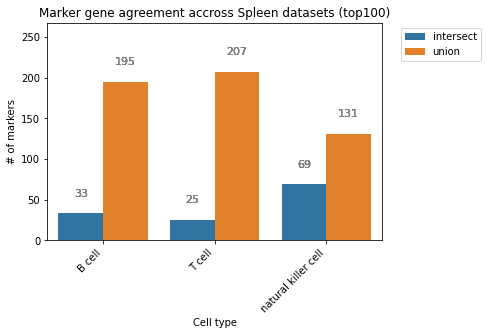

In [18]:
de_all, de_intersect = find_markers(adata, ['B cell', 'T cell', 'natural killer cell'])

In [19]:
len(de_all['B cell'])

195

In [20]:
len(de_intersect['B cell'])

33

# alternate ideas

In [64]:
def get_common_markers_within_tissue(de, celltypes):
    # Find markers for each celltypes that are common amongst all datasets
    _celltypes = []
    number_of_markers = []
    set_type = []
    # include = "sig100"
    include = "top100"
    ct_common_markers = {}
    for ct in celltypes:
        common_markers = None
        all_markers = None
        for i, mouse in enumerate(de.keys()):

            if include == "top100":
                curr_markers = de[mouse]['names'][ct][:100]
            elif include == "sig100":
                adj_pvals = de[mouse]['pvals_adj'][ct]
                idx = adj_pvals < 0.05
                sig = de[mouse]['names'][ct][idx]
                curr_markers = sig[:100]
            if common_markers is None:
                common_markers = set(curr_markers)
                all_markers = common_markers.copy()
            else:
                common_markers &= set(curr_markers)
                all_markers |= set(curr_markers)
        _celltypes.extend([ct] * 2)
        number_of_markers.extend([len(common_markers), len(all_markers)])
        set_type.extend(['intersect', 'union'])
        print(f"{ct} ({len(common_markers)}):\n{common_markers}")
        ct_common_markers[ct] = common_markers
    df = pd.DataFrame({'Cell type': _celltypes, '# of markers': number_of_markers, 'Markers': set_type})
    g = sns.barplot(x='Cell type', y='# of markers', hue='Markers', data=df, hue_order=['intersect', 'union'], ci=None)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    #ax=g.ax #annotate axis = seaborn axis
    def annotateBars(row, ax): 
        for p in ax.patches:
            ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 20),
                        textcoords='offset points')
    _ = df.apply(annotateBars, ax=g, axis=1)
    g.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    y_lim = g.get_ylim()
    g.set_ylim(y_lim[0], y_lim[1]+50)
    g.set_title(f"Marker gene agreement accross Spleen datasets ({include})")
    # plt.savefig(f"spleen_marker_agreement_{include}.png", bbox_inches="tight", dpi=300)
    return ct_common_markers

Index(['A1.B000610.3_56_F.1.1', 'A1.B002764.3_38_F.1.1',
       'A1.B002771.3_39_F.1.1', 'A1.D041914.3_8_M.1.1', 'A1.D042253.3_9_M.1.1',
       'A1.MAA000487.3_10_M.1.1', 'A10.B000610.3_56_F.1.1',
       'A10.B002764.3_38_F.1.1', 'A10.B002771.3_39_F.1.1',
       'A10.D041914.3_8_M.1.1',
       ...
       'P20.MAA000908.3_10_M.1.1', 'P21.B002431.3_39_F.1.1',
       'P21.MAA000594.3_8_M.1.1', 'P21.MAA000595.3_9_M.1.1',
       'P21.MAA000908.3_10_M.1.1', 'P22.B002431.3_39_F.1.1',
       'P22.MAA000906.3_11_M.1.1', 'P22.MAA000908.3_10_M.1.1',
       'P5.MAA000595.3_9_M.1.1', 'P8.MAA000595.3_9_M.1.1'],
      dtype='object', name='cell', length=44949)

(23433, 5862)

In [66]:
def find_markers(adata, celltypes, cache=None):
#     if cache is not None:
#         cache = Path(cache)
#         if cache.exists():
#             with open(cache, 'rb') as f:
#                 return pickle.load(f)
    markers_for_tissues = {}
    for tiss in adata.obs['tissue'].unique():
        print(tiss)
        tiss_subset = adata[adata.obs['tissue'] == tiss]
        de_for_mice = {}
        for mouse in tiss_subset.obs['mouse.id'].unique():
            print(mouse)
            mouse_subset = tiss_subset[tiss_subset.obs['mouse.id'] == mouse]
            print(mouse_subset.obs['cell_ontology_class'].value_counts())
            sc.tl.rank_genes_groups(mouse_subset, groupby='cell_ontology_class',
                                    groups=celltypes, method='wilcoxon',
                                    n_genes=adata.X.shape[1])
            de_for_mice[mouse] = mouse_subset.uns['rank_genes_groups']
        
        print(f"({tiss}) N significant markers for each cell type in each mouse:")
        for mouse, de in de_for_mice.items():
            print(mouse)
            for ct in celltypes:
                pvals = de['pvals_adj'][ct]
                n_sig = np.sum(pvals < 0.05)
                print(f"\t{ct}: {n_sig}")
        markers_within_tissue = get_common_markers_within_tissue(de, celltypes)
        markers_for_tissues[tiss] = markers_within_tissue
        
    all_ct_markers = {}
    for ct in celltypes:
        ct_markers = set()
        for tiss, markers in markers_for_tissues.items():
            ct_markers |= markers[ct]
        all_ct_markers[ct] = ct_markers
    
    return all_ct_markers

Index(['0610005C13Rik', '0610007C21Rik', '0610007L01Rik', '0610007N19Rik',
       '0610007P08Rik', '0610007P14Rik', '0610007P22Rik', '0610008F07Rik',
       '0610009B14Rik', '0610009B22Rik',
       ...
       'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'l7Rn6', 'zsGreen_transgene'],
      dtype='object', length=23433)

In [67]:
x.columns

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1',
       ...
       'N16.B002955.3_56_F.1.1', 'P9.B002955.3_56_F.1.1',
       'P10.B002955.3_56_F.1.1', 'E16.B002955.3_56_F.1.1',
       'H4.B002955.3_56_F.1.1', 'J4.B002955.3_56_F.1.1',
       'L1.B002955.3_56_F.1.1', 'M9.B002955.3_56_F.1.1',
       'N21.B002955.3_56_F.1.1', 'P11.B002955.3_56_F.1.1'],
      dtype='object', length=5862)

In [87]:
fat_df = x.T

In [88]:
fat_df.shape

(5862, 23433)

In [102]:
fat_idx = fat_df.index.intersection(cur_meta.index)
len(fat_idx)
fat_meta = cur_meta.loc[fat_idx]
#fat_meta = cur_meta[cur_meta.index.isin(fat_df.index)]

In [103]:
fat_meta.shape

(4967, 23)

In [104]:
fat_df = fat_df.loc[fat_idx]

In [97]:
fat_df.index[:10]

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1'],
      dtype='object')

In [98]:
import anndata

In [105]:
adata = anndata.AnnData(X=fat_df, obs=fat_meta)

In [106]:
adata

AnnData object with n_obs × n_vars = 4967 × 23433
    obs: 'Neurog3>0_raw', 'Neurog3>0_scaled', 'cell_ontology_class', 'cell_ontology_id', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'plate.barcode', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subsetE', 'subsetE_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2'

In [108]:
adata.obs_names

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1',
       ...
       'K15.B002955.3_56_F.1.1', 'M7.B002955.3_56_F.1.1',
       'N16.B002955.3_56_F.1.1', 'P9.B002955.3_56_F.1.1',
       'P10.B002955.3_56_F.1.1', 'E16.B002955.3_56_F.1.1',
       'H4.B002955.3_56_F.1.1', 'J4.B002955.3_56_F.1.1',
       'M9.B002955.3_56_F.1.1', 'P11.B002955.3_56_F.1.1'],
      dtype='object', length=4967)

In [109]:
adata.obs.index

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1',
       ...
       'K15.B002955.3_56_F.1.1', 'M7.B002955.3_56_F.1.1',
       'N16.B002955.3_56_F.1.1', 'P9.B002955.3_56_F.1.1',
       'P10.B002955.3_56_F.1.1', 'E16.B002955.3_56_F.1.1',
       'H4.B002955.3_56_F.1.1', 'J4.B002955.3_56_F.1.1',
       'M9.B002955.3_56_F.1.1', 'P11.B002955.3_56_F.1.1'],
      dtype='object', length=4967)

In [111]:
adata.X[0, 1:3]

array([13., 70.], dtype=float32)

In [112]:
fat_df.iloc[0, 1:3]

0610007C21Rik    13
0610007L01Rik    70
Name: B15.MAA000385.3_10_M.1.1, dtype: int64

In [113]:
fat_meta.iloc[0, 1:3]

Neurog3>0_scaled                NaN
cell_ontology_class    myeloid cell
Name: B15.MAA000385.3_10_M.1.1, dtype: object

In [114]:
adata.obs.iloc[0, 1:3]

Neurog3>0_scaled                NaN
cell_ontology_class    myeloid cell
Name: B15.MAA000385.3_10_M.1.1, dtype: object

In [116]:
adata.obs.index[0]

'B15.MAA000385.3_10_M.1.1'

In [120]:
fat_meta.index[100]

'N6.MAA000385.3_10_M.1.1'

In [121]:
fat_df.index[100]

'N6.MAA000385.3_10_M.1.1'

In [122]:
fat_df.index

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1',
       ...
       'K15.B002955.3_56_F.1.1', 'M7.B002955.3_56_F.1.1',
       'N16.B002955.3_56_F.1.1', 'P9.B002955.3_56_F.1.1',
       'P10.B002955.3_56_F.1.1', 'E16.B002955.3_56_F.1.1',
       'H4.B002955.3_56_F.1.1', 'J4.B002955.3_56_F.1.1',
       'M9.B002955.3_56_F.1.1', 'P11.B002955.3_56_F.1.1'],
      dtype='object', length=4967)

In [123]:
fat_meta.index

Index(['B15.MAA000385.3_10_M.1.1', 'D15.MAA000385.3_10_M.1.1',
       'F15.MAA000385.3_10_M.1.1', 'L15.MAA000385.3_10_M.1.1',
       'O4.MAA000385.3_10_M.1.1', 'P16.MAA000385.3_10_M.1.1',
       'H18.MAA000385.3_10_M.1.1', 'J16.MAA000385.3_10_M.1.1',
       'B17.MAA000385.3_10_M.1.1', 'D16.MAA000385.3_10_M.1.1',
       ...
       'K15.B002955.3_56_F.1.1', 'M7.B002955.3_56_F.1.1',
       'N16.B002955.3_56_F.1.1', 'P9.B002955.3_56_F.1.1',
       'P10.B002955.3_56_F.1.1', 'E16.B002955.3_56_F.1.1',
       'H4.B002955.3_56_F.1.1', 'J4.B002955.3_56_F.1.1',
       'M9.B002955.3_56_F.1.1', 'P11.B002955.3_56_F.1.1'],
      dtype='object', length=4967)